# Data Import Script
This script pulls in all relevant data for a session in my PhD experiment in raw form; it will process the data and save it to pickles for use.

In [169]:
import os
import cv2
import time
import pandas as pd
import numpy as np
import seaborn as sns
import humanize
import re
import glob
import math
import datetime
import pickle
from IPython.display import display, clear_output, HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import seaborn as sns
from csv import reader
from scipy.stats import beta
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from pympler import asizeof
from scipy import interpolate
from ahrs.filters import EKF
from ahrs import QuaternionArray
#%matplotlib inline
%matplotlib widget


TIMEZONE_OFFSET = 4

## E4 Data

by using `df = load_session_data('Data', 'P1', 'sess1')` this script will return a df with three columns: timestamp (ns), datatype (ACC, BVP, EDA, HR, IBI,or TEMP), and data (a list of values; typically a list with one value, but for acc we have three.)

This is one large df with all of the E4 data for that session.  Nicely for us, it is effectively 'done'.

To get dfs for each type of data separately, we can run `df_acc = extract_datatype(df, 'ACC')`.

In [2]:
def generate_timestamps(length, start_time, sample_rate):
    time_offset = np.arange(length) / sample_rate
    timestamps = pd.to_datetime(start_time, unit='s', origin='unix') + pd.to_timedelta(time_offset, unit='s') - datetime.timedelta(hours=TIMEZONE_OFFSET)
    return timestamps


def process_file(file_path, file_name):
    with open(file_path, 'r') as file:
        # only take the first timestamp
        start_time = float(file.readline().split(',')[0].strip())
        df = pd.DataFrame()
        if 'IBI' in file_name:
            data = pd.read_csv(file, header=None, names=['time', 'ibi']).values.tolist()
            df['timestamp'] = pd.to_datetime([item[0] + start_time for item in data], unit='s', origin='unix')
        else:
            sample_rate = float(file.readline().split(',')[0].strip())
            data = pd.read_csv(file, header=None).values.tolist()
            df['timestamp'] = generate_timestamps(len(data), start_time, sample_rate)
            
            if 'ACC' in file_name:
                #accelerometer data is in 1/64 Gs.  Our glasses data is in m/s^2. Transform it to m/s^2
                data = [[(i/64)*9.8 for i in l] for l in data]
        df['datatype'] = file_name.split('.')[0]
        df['data'] = data
        return df

    
def load_session_data(folder, participant_id, session_id):
    data_dir = f'{folder}/{participant_id}/{participant_id}_{session_id}'
    data_frames = []

    expected_files = ['ACC.csv', 'BVP.csv', 'EDA.csv', 'HR.csv', 'IBI.csv', 'TEMP.csv']

    #load all files, save the output of 'process_file' into data_frames
    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            if file in expected_files:
                file_path = subdir + os.sep + file
                df = process_file(file_path, file)
                data_frames.append(df)
    
    #turn data_frames into df
    final_df = pd.concat(data_frames)
    final_df.set_index('timestamp', inplace=True)
    final_df.sort_index(inplace=True)
    
    return final_df


def extract_datatype(df, datatype):
    # Filter the dataframe for the given datatype
    df_filtered = df[df['datatype'] == datatype].copy()
    
    # Determine the number of columns based on the length of the 'data' list in the first row
    num_cols = len(df_filtered['data'].iloc[0])
    
    # Create column names
    col_names = ['d' + str(i + 1) for i in range(num_cols)]
    
    # Split the 'data' list into multiple columns
    df_split = pd.DataFrame(df_filtered['data'].to_list(), columns=col_names)
    
    # Add timestamp back to the dataframe
    df_split.index = df_filtered.index
    
    return df_split

def plot_df(df, title):
    fig, ax = plt.subplots(figsize=(15, 3))

    # Assuming df has timestamp as index
    for column in df.columns:
        if 'tick' not in column:
            sns.lineplot(data=df, x=df.index, y=column, ax=ax, lw=1.5)
        
    # Format the x axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Set grid
    ax.grid(True, which="both", color='gray', linewidth=0.25)

    # Set title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Value', fontsize=11)

    # Set legend
    #ax.legend(loc='upper left', fontsize=14)

    # Set tick parameters
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Improve date tick display
    fig.autofmt_xdate()

    plt.show()

In [3]:
folder = 'Data'
user = 15
session = 2

#load in the E4 data
df = load_session_data(folder, 'P' + str(user), 'sess' + str(session))

df.head(5)

,datatype,data
timestamp,,
2023-04-22 14:18:56.000000,TEMP,[25.17]
2023-04-22 14:18:56.000000,BVP,[-0.0]
2023-04-22 14:18:56.000000,ACC,"[0.30625, -9.646875000000001, 0.765625]"
2023-04-22 14:18:56.000000,EDA,[0.0]
2023-04-22 14:18:56.015625,BVP,[-0.0]


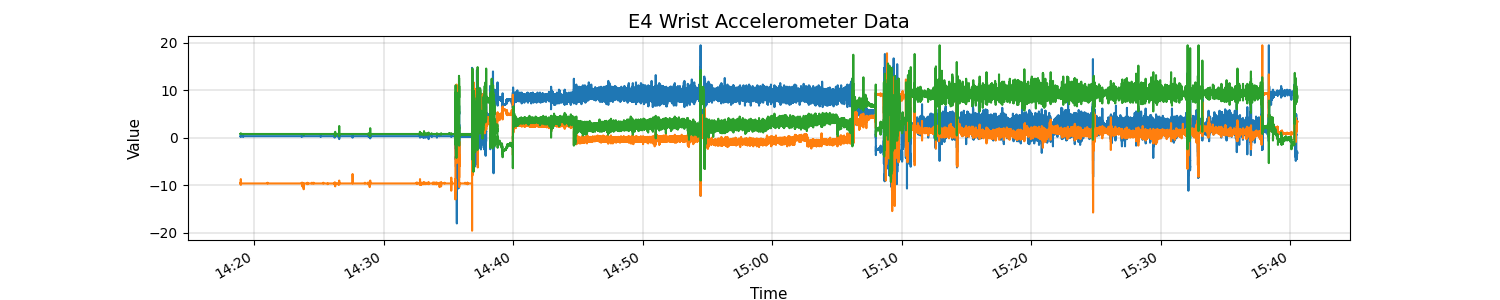

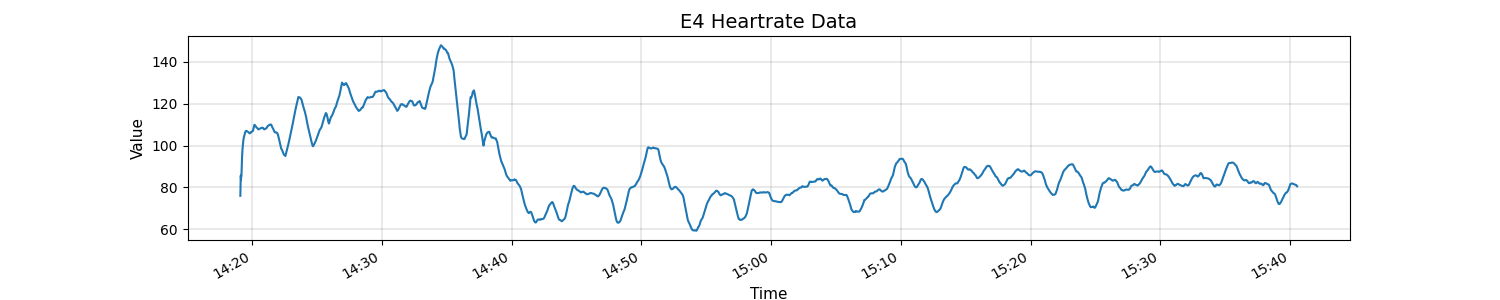

In [44]:
#grab, i.e. just the accelerometer data and plot; could do the same for IBI, TEMP, EDA, BVP
df_acc = extract_datatype(df, 'ACC')
plot_df(df_acc, 'E4 Wrist Accelerometer Data')

df_hr = extract_datatype(df, 'HR')
plot_df(df_hr, 'E4 Heartrate Data')

What to do with the data here?  

#### ACC (32 Hz, m/s^2)

Accelerometer data comes in at 1/64 Gs (ints) and needs to be transformed by 1/64 g (that's equivalent to '1'; 128 should give us 2G, -128 should give us -2G).  We then multiply by 9.8m/s^2 to get a similar value to our accelerometer on the glasses.

For accelerometer data at the wrist, we might want to do a few things: (1) look over a time window and make a judgement about wrist movement-- is it a lot, or a little?  We may want to use that movement as a signal for how much we should trust the other sensors, which are contact based and can be pretty corrupted by motion artifacts.  

We can transform these three axes of motion into a vector, and see how different it is from an estimated gravity vector (resting, some stillness assumptions, etc).  Wrist stillness *may* tell us something about focus state, but probably not too much directly unless someone was engaged passively in something.  Perhaps the most interesting thing we could draw from it are patterns in the data, which summary statistics would destroy.  We can do a self-similarity matrix-style approach to build out some statistics on patterns in the accelerometer data

#### BVP (64 Hz, unitless reflectance ratio)

Raw PPG signal.  We may not need to look at this really-- our preference would be to derive HR and HRV/IBI from it anyway.  Maybe there is some interesting stuff in the raw signal, but that's out of scope.  Whats probably useful (if anything) is looking to see if the raw data looks trustworthy, and to check if we trust empatica's derivation of HR and IBI.  By running our own algorithm on the raw data, we might have a sense of confidence in our results.  We can also take into consideration the Accelerometer data once it's been transformed to a simple 'magnitude of motion' measure. 

#### HR (1 Hz, BPM)

A derived signal from the BVP, this is grabbing the anticipated HR.  We may want to assess the quality of BVP and their HR algorithm on our own to see how well they're doing; we may also want to throw away data when motion is an issue.  This derived signal lends itself easily to summary stats/time slices.

#### IBI (No Hz-- get them after each detected heartbeat-- so likely between 5 and 25 Hz, milliseconds)

This is a processed signal, we can probably just do some summary stats on it over various windows.  Once again it relies on the BVP raw signal.

#### EDA (4 Hz, uSiemens)

This is one of the signals that needs the most processing work; we typically do quite a bit of cleanup, and split out SCR (transients) from SCL (low-frequency content).  10% of users are estimated to be non-responders.  This one will require a lot of cleaning.

#### TEMP (4 Hz, degrees C)

No cleaning necessary for skin temperature.  We'll use it in concert with the other temperature values we've been collecting.




## Glasses and Watch Data

We have more work to do on the glasses data, because it doesnt come with the preprocessing completed for us.  We have:

(1) Accelerometer Data.  We can use similar accelerometer code as above.

(2) Gyro Data.  We can combine with Accelerometer in a Kalman filter to get a sense of head orientation.  Potentially very interesting.

(3) Nose and Temple Temp and Ambient Temp/Humidity data.  These come in at different rates and have different calibrations, but once applied this is straightforward to work with (we just have to do the processing).

(4) Blink data.  Potentially a lot of sophisticated stuff to pull out here, but we can just start with a simple script that has some basic hueristics about blink duration and frequency content built into it.

(5) Ambient Light data.  No real hard stuff here, just gotta calibrate correctly.

In [4]:
folder = 'Data'
user = 15
session = 2

In [5]:
def get_size_mb(obj):
    size_bytes = asizeof.asizeof(obj)
    size_mb = size_bytes / (1024 * 1024)  # Convert bytes to megabytes
    return size_mb

def interpolate_df(df, start_timestamp, end_timestamp, new_freq):
    # Calculate the total time duration of the data in seconds
    total_time = (end_timestamp-start_timestamp).total_seconds()
    
    # Create new timestamp index at the desired frequency
    new_index = pd.date_range(start=start_timestamp, periods=int(total_time * new_freq), freq=f'{1/new_freq*1000}ms')

    # Initialize new DataFrame with the new index
    df_new = pd.DataFrame(index=new_index)

    # For each column in the original DataFrame, interpolate to the new frequency
    for col in df.columns:
        # Create spline interpolator for this column
        interpolator = interpolate.interp1d(df.index.values.astype(float), df[col].values, kind='cubic')

        # Interpolate this column at the new timestamps
        df_new[col] = interpolator(new_index.values.astype(float))

    return df_new

def load_session_excel(folder, participant_id, session_id):
    
    # grab all filepaths in there, in order.
    data_dir = f'{folder}/{participant_id}/{participant_id}_{session_id}'
    filepaths = sorted(glob.glob( data_dir + '/*.csv'))
    
    session_data = []
    
    # process all of them
    for file in filepaths:
        
        print('\n\nProcessing ' + file)
        # pull out timestamp and session type
        pattern = r".*/(\d{6})_(\d{6})_p\d+_(.*).csv"
        match = re.search(pattern, file)
        
        date_str = match.group(1)
        time_str = match.group(2)
        session_type = match.group(3)
        
        # Convert the date and time to a pandas.Timestamp object
        timestamp = pd.to_datetime(date_str + time_str, format='%m%d%y%H%M%S')
        
        logs, blinks, acc, gyro, thermal, ui, wtemp, wlux = [], [], [], [], [], [], [], []

        with open(file, 'r') as read_obj:
            csv_reader = reader(read_obj)
            for row in csv_reader:
                try:
                    if   (row[0]=='l'):
                        logs.append(row[1:])
                    elif (row[0]=='g'):
                        if   (row[2]=='b'):
                            blinks.append(row[1:])
                        elif (row[2]=='t'):
                            thermal.append(row[1:])
                        elif (row[2]=='a'):
                            acc.append(row[1:])
                        elif (row[2]=='g'):
                            gyro.append(row[1:])
                    elif (row[0]=='u'):
                        ui.append(row[1:])
                    elif (row[0]=='w'):
                        if(row[3] == 'TX_TEMP_HUMD'):
                            wtemp.append(row[1:])
                        elif(row[3] == 'TX_LUX_WHITELUX'):
                            wlux.append(row[1:])
                except Exception as e:
                    print(str(e) + ': ' + str(row))

        print('got raw data.')
        
        print('\tthermal processing...')
        check_raw_packets(thermal, timeout_ms=4200)
        thermal_df = pd.DataFrame()
        for t in thermal:
            thermal_df = pd.concat([thermal_df, parseThermalRow(t)], axis=0)    
        thermal_df.reset_index(inplace=True)
        thermal_df = reindex_to_timestamp(thermal_df)
        
        thermal_df['nose_tp_rolling'] = thermal_df['nose_tp'].rolling(7).mean()
        thermal_df['temple_tp_rolling'] = thermal_df['temple_tp'].rolling(2).mean()
        thermal_df['nose_thermistor_rolling'] = thermal_df['nose_thermistor'].rolling(40).mean()
        thermal_df['temple_thermistor_rolling'] = thermal_df['temple_thermistor'].rolling(40).mean()
        thermal_df['nose_temp_C'] = thermal_df.apply(lambda x: convert_nose_temp(x['nose_tp_rolling'], x['nose_thermistor_rolling']), axis=1)
        thermal_df['temple_temp_C'] = thermal_df.apply(lambda x: convert_temple_temp(x['temple_tp_rolling'], x['temple_thermistor_rolling']), axis=1)
        thermal_df['differential_C'] = thermal_df['nose_temp_C'] - thermal_df['temple_temp_C']
        thermal_df['differential_C_rolling'] = thermal_df['differential_C'].rolling(15).mean()      
        
        print('\tgyro processing...')
        check_raw_packets(gyro, timeout_ms=900)
        gyro_df = parse_xyz_data(gyro)
        gyro_df.reset_index(inplace=True)
        gyro_df = reindex_to_timestamp(gyro_df)
        gyro_df = gyro_df[gyro_df['x'] < 10000]
        gyro_df = gyro_df[gyro_df['y'] < 10000]
        gyro_df = gyro_df[gyro_df['z'] < 10000]
        
        #convert int16s to floats with q=9.
        #this gives us rad/s (angular velocity), we expect values in the 0.3-3 range.
        #Gyro set to updates every 10ms, or 100Hz
        gyro_df['x'] = gyro_df['x'].astype(float) / 512
        gyro_df['y'] = gyro_df['y'].astype(float) / 512
        gyro_df['z'] = gyro_df['z'].astype(float) / 512
        
        print('\taccelerometer processing...')
        check_raw_packets(acc, timeout_ms=1350)
        acc_df = parse_xyz_data(acc)
        acc_df.reset_index(inplace=True) 
        acc_df = reindex_to_timestamp(acc_df)
        acc_df = acc_df[acc_df['x'] < 10000]
        acc_df = acc_df[acc_df['y'] < 10000]
        acc_df = acc_df[acc_df['z'] < 10000]
        
        #convert int16s to floats with q=8.
        #this gives us data in m/s^2, so we expect ~9.8 when at rest
        #accelerometer set for every 20ms, or 50Hz
        acc_df['x'] = acc_df['x'].astype(float) / 256
        acc_df['y'] = acc_df['y'].astype(float) / 256
        acc_df['z'] = acc_df['z'].astype(float) / 256
        
        print('\tquaternion extended kalman filter application...')
        start_timestamp = max(acc_df.index[0], gyro_df.index[0])
        end_timestamp = min(acc_df.index[-1], gyro_df.index[-1])

        acc_inter = interpolate_df(acc_df, start_timestamp, end_timestamp, 100)
        gyro_inter = interpolate_df(gyro_df, start_timestamp, end_timestamp, 100)

        ekf = EKF(gyr=gyro_inter[['x','y','z']].values, acc=acc_inter[['x','y','z']].values, frequency=100.0)
        qs = QuaternionArray(ekf.Q)
        qs.remove_jumps()
        qs_df = pd.DataFrame({'w': qs[:,0], 'i':qs[:,1], 'j':qs[:,2], 'k':qs[:,3]}, index=acc_inter.index)
        
        print('\tblink processing...')
        check_raw_packets(blinks, timeout_ms=500)
        blinks_df = parse_blink_rows(blinks)
        blinks_df.reset_index(inplace=True)
        blinks_df = reindex_to_timestamp(blinks_df)
        
        print('\twatch processing...')
        wtemp_df = processWatchTemp(wtemp)
        wlux_df = processWatchLux(wlux)
        
        session = {
            'user': participant_id,
            'session': session_id,
            'filepath': file,
            'session_type': session_type,
            'timestamp': timestamp,
            'logs': logs,
            'blinks': blinks_df,
            'acc': acc_df,
            'gyro': gyro_df,
            'quaternions': qs_df,
            'thermal': thermal_df,
            'ui': ui,
            'watch_temp': wtemp_df,
            'watch_lux': wlux_df
        }
        
        session_data.append(session)
    
    print(f"The size of the loaded data is {get_size_mb(session_data)} MB")
    return session_data


def processWatchTemp(watch_data):
    '''Apply simple calibration to temp data based on comparison with cheap temp/humd gauge from amazon.
    Also, process the timestamp and turn it into a df'''
    
    to_df = []    
    
    for item in watch_data:
        to_df.append({
            'timestamp':pd.to_datetime(item[1]),
            'temp': 21.2 + (6.7/5.4) * (float(item[3])-24),
            'humidity': float(item[4])
        })
    
    df = pd.DataFrame(to_df)

    try:
        df['timestamp'] = df['timestamp'].dt.tz_localize(None)
        df.set_index('timestamp', inplace=True)
    except:
        print('\t\tno entries')

    return df

def processWatchLux(watch_data):
    
    to_df = []    
    for item in watch_data:
        to_df.append({
            'timestamp':pd.to_datetime(item[1]),
            'lux': float(item[3]),
            'whitelux': float(item[4])
        })
    
    df = pd.DataFrame(to_df)
    try:
        df['timestamp'] = df['timestamp'].dt.tz_localize(None)
        df.set_index('timestamp', inplace=True)
    except:
        print('\t\tno entries')
    return df

def parse_blink_rows(blinks):
    blink_rows = []
    
    for b in blinks:
        packetLength = int(b[6])
        blink_df_row = pd.DataFrame(data=[b[0:12] for i in range(packetLength)], 
                                    columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 
                                             'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
        
        
        blink_df_row["data"] = pd.Series([int(v) for v in b[13:]], dtype=np.int32)
        blinkSampleRate = 2000 # 2kHz
        blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 0.5 ms
        blink_df_row["tick_ms"] = blink_df_row['msFromStart'].astype(int)
        blink_df_row["tick_ms"] /= 2
        blink_df_row["tick_ms"] -= (packetLength - np.array(range(1, packetLength+1))) * blinkSamplePeriod_ms
        blink_df_row["saturated"] = blink_df_row["res0"].astype(int)
        blink_rows.append(blink_df_row)   
     
    return pd.concat(blink_rows)
 
    
def parse_xyz_data(data):
    def parseXYZRow(p):
        packetLength = 25
        base_data = p[0:12]
        other_data = np.array(p[13:]).astype('int32').reshape(-1,5)
        return [(base_data + list(row)) for row in other_data]

    data_out = []
    for d in data:
        data_out.extend(parseXYZRow(d))

    df = pd.DataFrame(data_out, columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4', 'x','y','z','imu_tick_ms','tick_ms'])
    
    df["tick_ms"] = df["tick_ms"]/2
    
    return df


def parseThermalRow(t):
    tempSamplePeriod_ms = 100
    numInnerPackets = 4
    rowsInInnerPacket = 5
    # each row has 128 values; 4x 32 value 'packets'; 
    # each 32 has 5 repetitions of 6 values of data + 2 (tick,epoch)
    # these 6 values are interleaved; i.e. the first three are temple numbers, and the first
    # 15 sets of three are temple vals; the second 15 sets of 3 are the corresponding nose vals.
    # to get a timestamped packet, we need [0,1,2] matched with [15,16,17] and so on within each
    # 32 value 'packet'.  
    
    df_row = pd.DataFrame(data=[t[0:12] for i in range(numInnerPackets*rowsInInnerPacket)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    
    payload = np.array(t[13:]).astype(np.int32).reshape(numInnerPackets, -1)
    
    def flatten(t): return [item for sublist in t for item in sublist]
    reindex = flatten([[*range(i*3,i*3+3)] + [*range(15+i*3, 18+i*3)] + [-2,-1] for i in range(rowsInInnerPacket)])
    proper_payload = payload[:,reindex].reshape(-1,8)
    
    df_row = pd.concat([df_row, pd.DataFrame(data=proper_payload, columns=["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"])], axis=1)
    df_row['tick_ms'] -= tempSamplePeriod_ms * np.array([4,3,2,1,0] * numInnerPackets)
    
    return df_row

def convert_thermistor_to_K(raw_value):
    # STEP 1. Calc R_thermistor value given ADC_val
    R_divider = 100000
    ADC_max = 4095
    
    R_t = (R_divider * raw_value/ADC_max) / (1 - raw_value/ADC_max)
    
    # STEP 2. Convert R_t to temp
    R_0 = 100000
    T_0 = 298.15
    Beta = 3960
    R_inf = R_0 * math.exp(-Beta/T_0)
    
    Temp_K = Beta / np.log(R_t / R_inf)
    return Temp_K
    
def convert_thermopile_to_C(raw_val, T_ref_K, A, a_0, a_1):
    #STEP 1. Calc V_thermopile based on preamp gain and bias
    V_tp = (((raw_val / 4095) * 3.3) - (1.15+0.6084))/1000.0
    
    #STEP 2. Solve for Temperature!
    f_V_tp = (V_tp - a_0) + a_1 * (V_tp - a_0)**2
    T_obj = (T_ref_K**4 + f_V_tp/A)**0.25
    return (T_obj - 273.15)
    
def convert_nose_temp(raw_val, raw_thermistor):
    A   =  7.8e-10
    a_0 = -2.31e-01
    a_1 =  3.61e-03
    try:
        return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    except:
        return np.nan
    
def convert_temple_temp(raw_val, raw_thermistor):
    A   =  4.21e-10
    a_0 = -3.62e-01
    a_1 =  8.31e-02
    try:
        return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    except:
        return np.nan
    

def check_raw_packets(data, timeout_ms=500):
    last_seen = pd.to_datetime(data[0][0]) #0 = serverTimestamp
    last_tick = int(data[0][4]) #4 = packet_tick
    last_packet = int(data[0][3]) #3 = packetNum
    packets = set() 
    packets.add(last_packet)

    for i, d in enumerate(data[1:]):

        current_seen = pd.to_datetime(d[0])
        current_packet = int(d[3])
        current_tick = int(d[4])

        # Check if serverTimestamp is proceeding in order, which it should. 
        if current_seen < last_seen:
            print(f"\t\t-- at index {i+1}: Timestamp out of order. Current: {current_seen}, Previous: {last_seen}")

        # Check for duplicate packetNumbers by checking for the number in set packets.
        #if current_packet in packets:
        #    print(f"Error at index {i+1}: Duplicate packetNum detected. packetNum: {current_packet}")

        # Make sure packetNum is one larger than previous.
        if current_packet != last_packet + 1 and current_packet != 0:
            print(f"\t\tat index {i+1}: packetNum not sequentially increasing. Current: {current_packet}, Previous: {last_packet}")

        # Make sure tick has increased from last_tick.
        if current_tick <= last_tick:
            print(f"\t\tat index {i+1}: packet_tick not increasing. Current: {current_tick}, Previous: {last_tick}")

        # Check if the current tick is no more than 500ms greater than last tick.
        if current_tick - last_tick > timeout_ms:
            print(f"\t\tat index {i+1}: tick increment greater than timeout. Difference: {current_tick - last_tick}ms")

        # Update last_seen, last_tick, last_packet, packets
        last_seen = current_seen
        last_tick = current_tick
        last_packet = current_packet

        
        
def check_time_deltas(data):
    ''' feed in raw data after reading it into a list, this will just check
    server timestamps vs packet vs ticks and look at the differences elapsed 
    from packet to packet.  For debugging. '''
    prev_server = pd.to_datetime(data[0][0])
    prev_packet = int(data[0][3])
    prev_tick   = int(data[0][4])

    for d in data[1:200]:
        cs = pd.to_datetime(d[0])
        cp = int(d[3])
        ct = int(d[4])
        
        print(f'Differences: PACKET:{cp-prev_packet}\tSERVER:{humanize.precisedelta(cs-prev_server)}\tTICK:{(ct-prev_tick)/1000}')
        
        prev_server = cs
        prev_packet = cp
        prev_tick   = ct
        

def reindex_to_timestamp(df, column='tick_ms'):
    '''assumes a serverTS and tick_ms.  grabs first serverTS, assumes it marks 
    the tick_ms of the last row in the first packet, and then uses the tick_ms
    as the gold standard for all other timestamps'''
    
    df = df.copy()

    #make sure column is a datetime type
    df[column] = pd.to_datetime(df[column], unit='ms')
    
    # Set the first serverTS as the base timestamp
    base_timestamp = pd.to_datetime(df.loc[0, 'serverTS'])

    # Find the tick_ms of the last entry in the first packet by looking at the change in packetNum
    first_packet_num = df.loc[0, 'packetNum']
    zero_time_index = np.where(df['packetNum'].shift(-1) != first_packet_num)[0]
    
    if len(zero_time_index) > 0:
        zero_time = df.loc[zero_time_index[0], column]
    else:
        zero_time = df.loc[0, column]

    # Adjust tick_ms to get the correct offset
    df.loc[:, column] -= zero_time
    df.loc[:, column] = pd.to_timedelta(df[column], unit='ms')

    
    # Create new timestamp and set as index
    df['timestamp'] = base_timestamp + df[column]
    
    # Drop duplicates
    l = len(df)
    df.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    print(f'\t\tdropped {l-len(df)} rows of data due to duplication.')
    
    # Drop data that's not within 10 sec of first and last server timestamp
    l = len(df)
    cutoff = pd.to_datetime(df.iloc[0]['serverTS']) - datetime.timedelta(seconds=10)
    df = df[df['timestamp'] > cutoff]
    cutoff = pd.to_datetime(df.iloc[-1]['serverTS']) + datetime.timedelta(seconds=10)
    df = df[df['timestamp'] < cutoff]
    print(f'\t\tdropped {l-len(df)} rows of data due to weird timestamps.')
    
    df['timestamp'] -= datetime.timedelta(hours=TIMEZONE_OFFSET)
    
    df.set_index('timestamp', inplace=True)
    
    print('\t\t-----------------------------')
    #print('\t\t-- reindexed timestamps based on first packet server timestamp and last tick_ms of first packet')
    #print('\t\t-- there is the possibility of drift with this technique; check that these values of the')
    #print('\t\t-- final packet are roughly in sync.')
    #print('\t\t-- First server time: ' + pd.to_datetime(df['serverTS'].iloc[0]).time().isoformat())
    #print('\t\t-- Last server time: ' + pd.to_datetime(df['serverTS'].iloc[-1]).time().isoformat())
    #print('\t\t-- First timestamp: ' + df.index[0].time().isoformat())
    #print('\t\t-- Last timestamp: ' + df.index[-1].time().isoformat())
    #print('\t\t-- Duration serverTS:  ' + humanize.precisedelta(pd.to_datetime(df['serverTS'].iloc[-1])-pd.to_datetime(df['serverTS'].iloc[0])))
    #print('\t\t-- Duration timestamp: ' + humanize.precisedelta(df.index[-1]-df.index[0]))
    print('\t\tDuration: ' + humanize.precisedelta(df.index[-1]-df.index[0]))
    print('\t\tError (server timestamp vs tick): ' + humanize.precisedelta(pd.to_datetime(df['serverTS'].iloc[-1]) - df.index[-1] - datetime.timedelta(hours=TIMEZONE_OFFSET)))
    print('\t\t% drift: ' + str(100.0*(pd.to_datetime(df['serverTS'].iloc[-1]) - df.index[-1] - datetime.timedelta(hours=TIMEZONE_OFFSET))/(df.index[-1]- df.index[0])))
     
    df.drop([column, 'serverTS', 'msFromStart','index','packetTypeLetter','packetType','packetNum','epoch','packetSize','res0','res1','res2','res3','res4'], axis=1, inplace=True)

    return df

In [6]:
session_data = load_session_excel(folder, 'P' + str(user), 'sess' + str(session))



Processing Data/P15/P15_sess2/042223_143955_p15_HOME_TETRIS.csv
got raw data.
	thermal processing...
		dropped 0 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 14 minutes and 37.90 seconds
		Error (server timestamp vs tick): 0.04 seconds
		% drift: -0.004670235789953297
	gyro processing...
		at index 523: packetNum not sequentially increasing. Current: 141, Previous: 141
		at index 523: packet_tick not increasing. Current: 3133542, Previous: 3133542
		at index 538: packetNum not sequentially increasing. Current: 157, Previous: 155
		at index 538: tick increment greater than timeout. Difference: 1182ms
		at index 660: packetNum not sequentially increasing. Current: 24, Previous: 22
		at index 660: tick increment greater than timeout. Difference: 1268ms
		at index 2002: packetNum not sequentially increasing. Current: 87, Previous: 85
		at index 2002: tick increment greater than timeout. Difference: 1173ms
	

/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)


In [7]:
for s in session_data:
    print(s['timestamp'], s['user'], s['session'], s['session_type'])

2023-04-22 14:39:55 P15 sess2 HOME_TETRIS
2023-04-22 14:54:33 P15 sess2 TETRIS_CONTD
2023-04-22 15:10:55 P15 sess2 HOME_FLOW
2023-04-22 15:24:49 P15 sess2 FLOW_CONTD
2023-04-22 15:55:02 P15 sess2 HOME_TETRIS_RESUME
2023-04-22 15:55:42 P15 sess2 HOME_TETRIS_RESUME


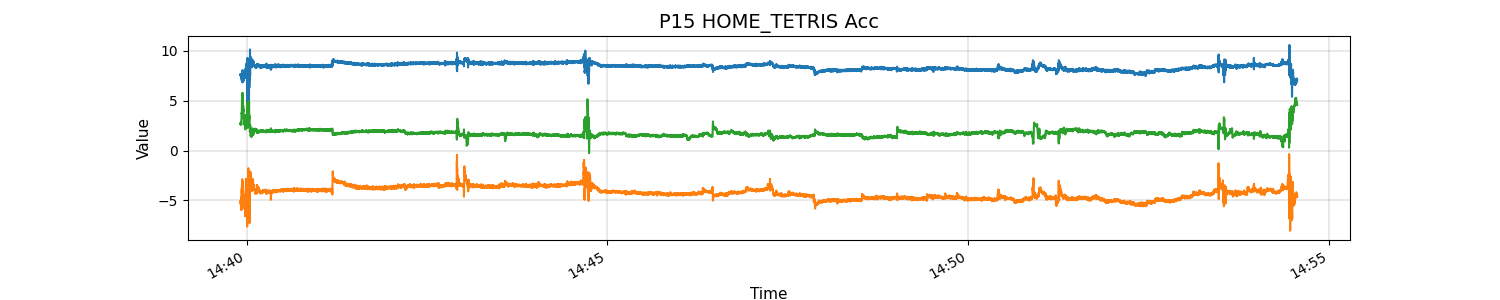

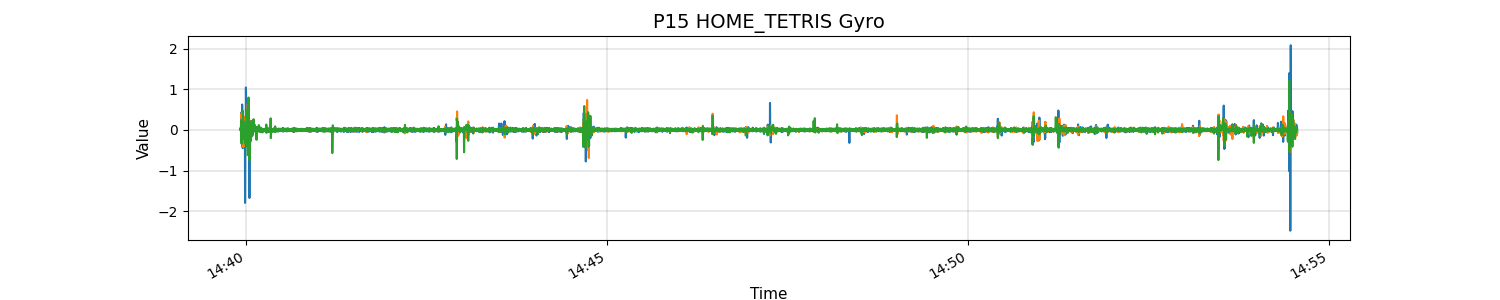

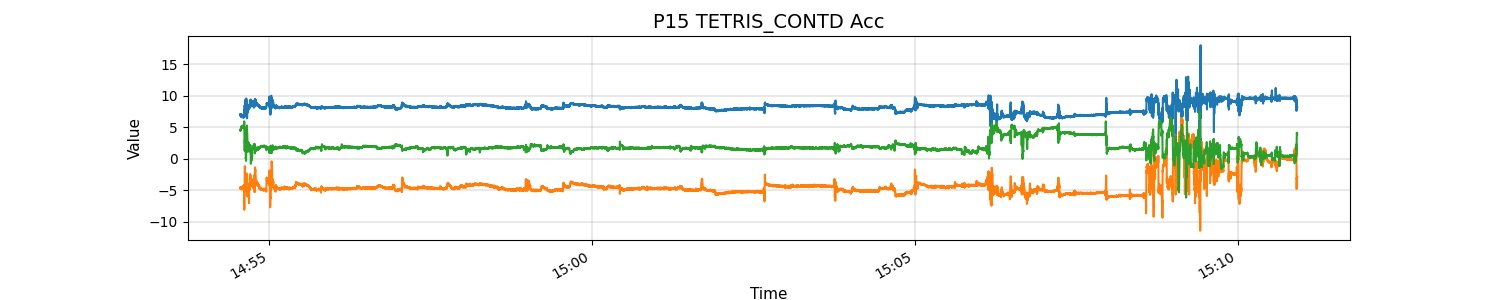

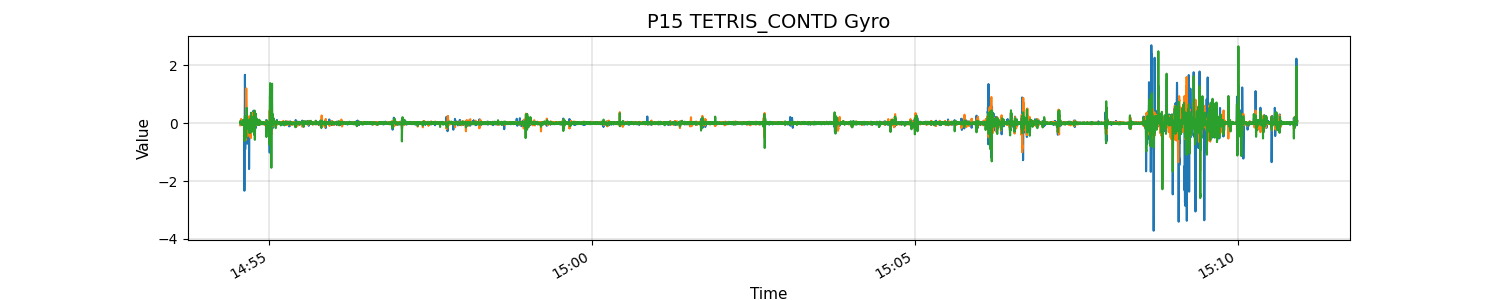

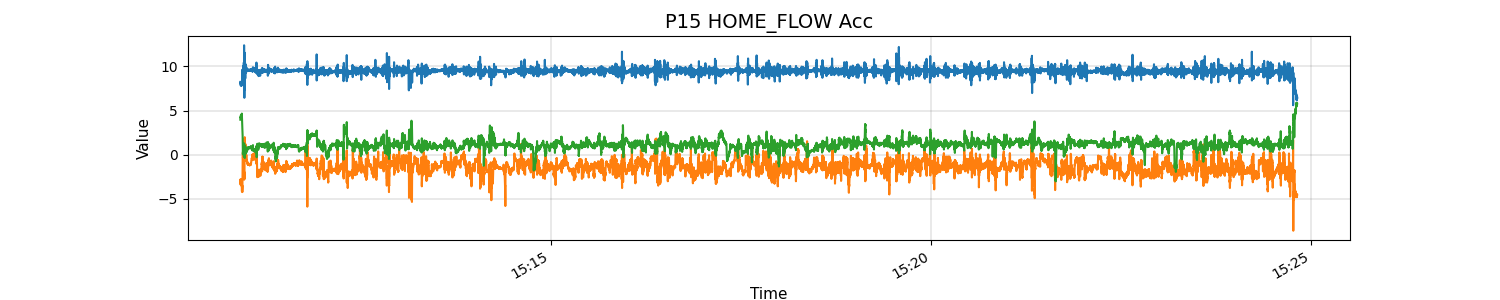

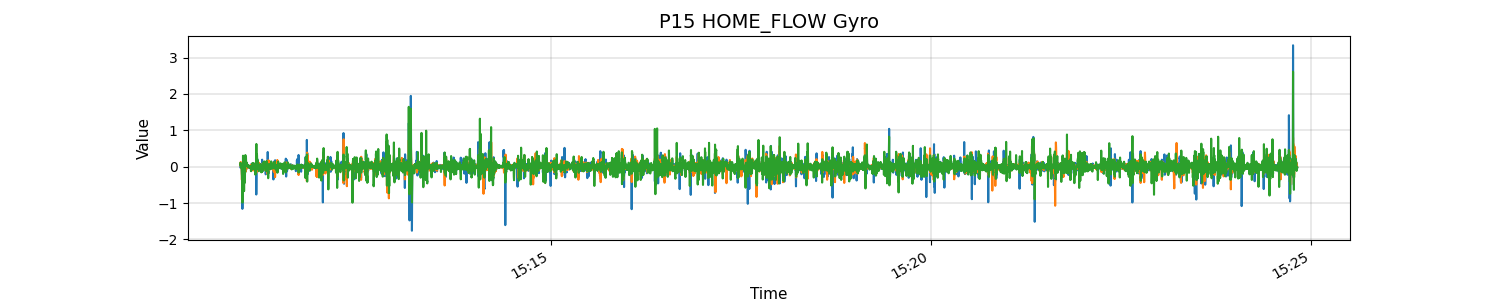

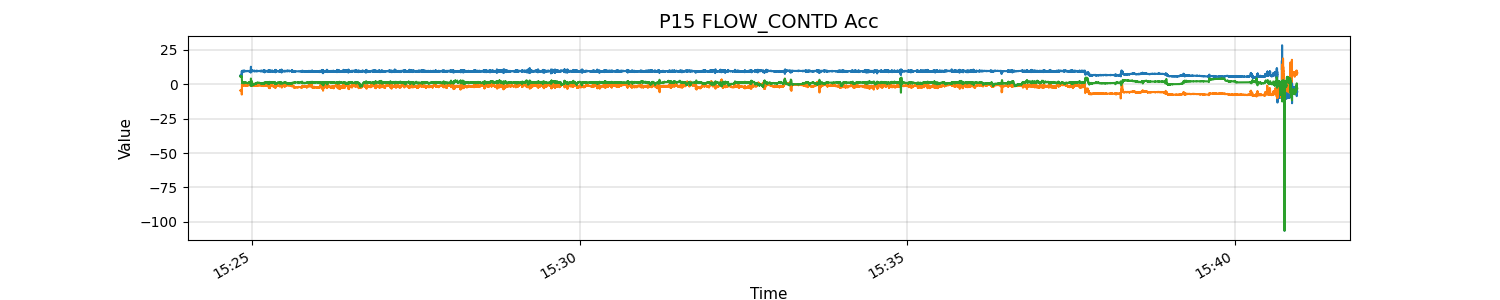

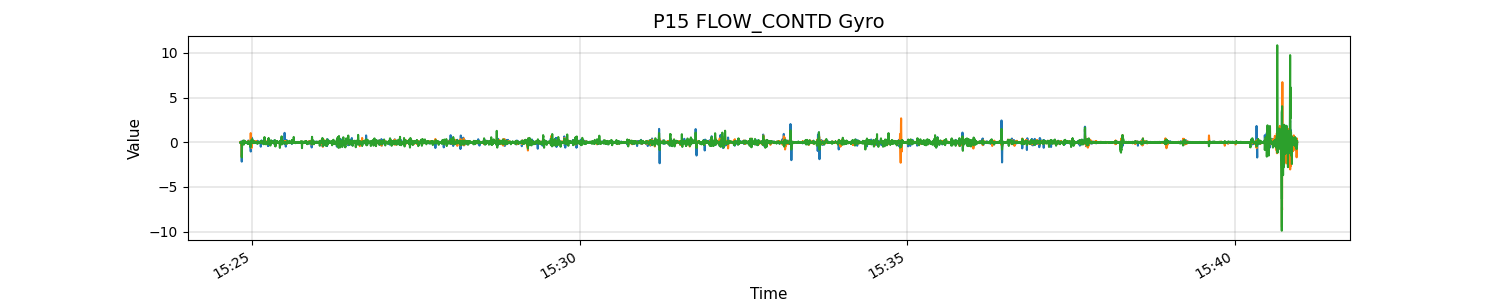

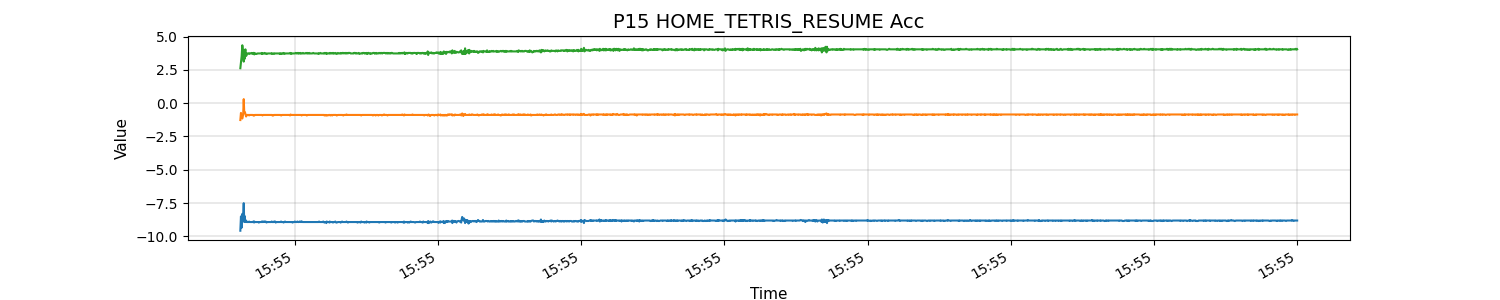

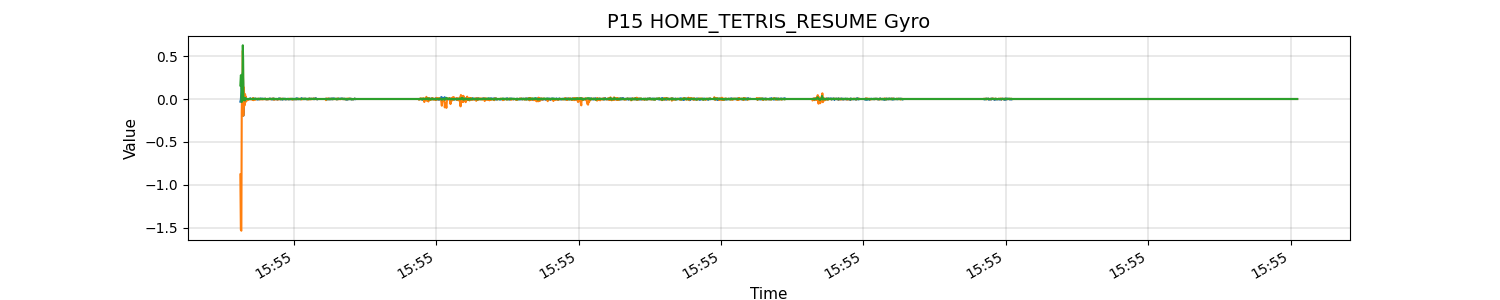

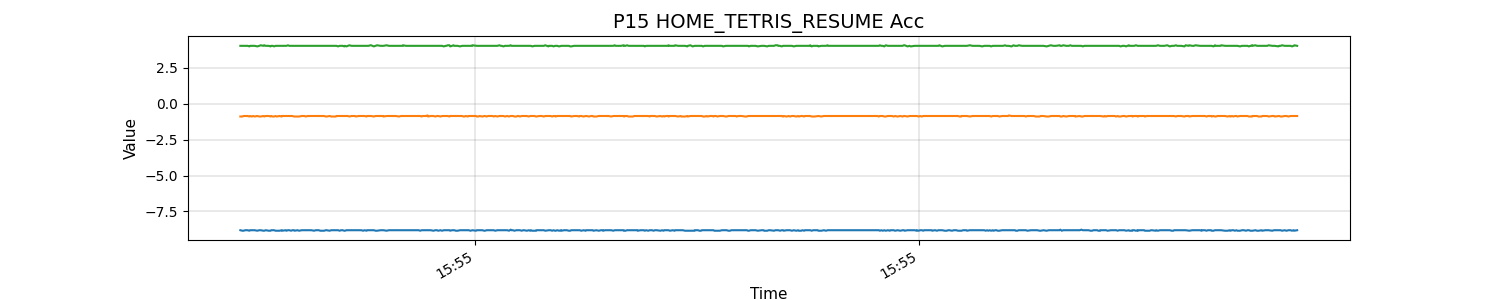

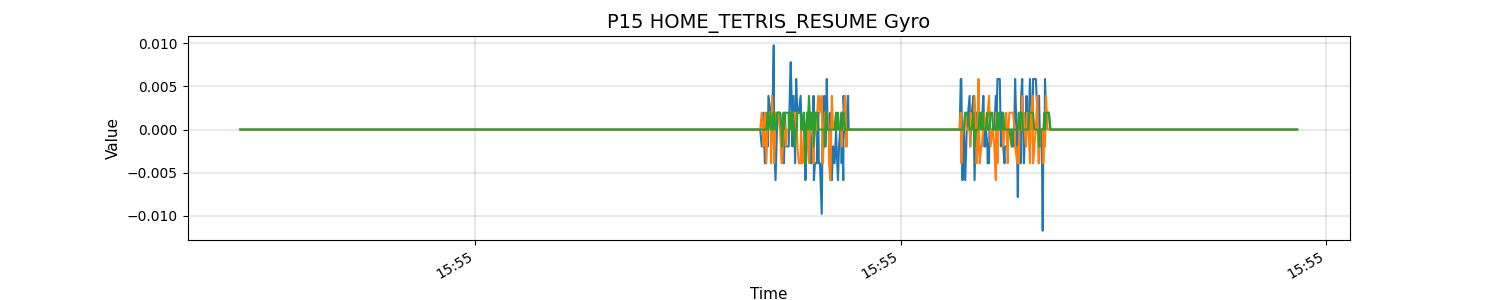

In [17]:
for s in session_data:
    plot_df(s['acc'], s['user'] + ' ' + s['session_type'] + ' Acc')
    plot_df(s['gyro'], s['user'] + ' ' + s['session_type'] + ' Gyro')

## Behavioral and Survey Data

We need to process some data that will be useful for us to make estimates about what's going on here.  Below we'll start to group the data from the surveys by section:

These have specific ways to process.

- standard flow test data for each section (FSS, etc)
- standard wellbeing questionaire 
- standard TAS (absorption trait)

These do not:
- standard affect (affect model of flow) -- alertness and valence, reaction times, stress (interesting work to look at alertness vs. reaction time).
- free text answers about caffeine, life, stress, factors that matter that we're not measuring.
- enjoyment of tetris, enjoyment of games, self-perceived skill

Things that are going to get interesting to model and definitely don't have prior art for processing them:

- time perception data (durations, clock time, confidence)
- duration voluntarily continuing the task
- duration until noticing of light
- additional flow datapoints, including the drawn data.

In this section, we'll just organize the data.

In [119]:
#All combined

def get_user_entrance_responses(folder, user):
    '''grab the entrance survey results from google form csv'''
    
    df = pd.read_csv(folder + '/Flow_Entrance_Survey.csv')

    # Filter DataFrame to get row of specified user  
    user_row = df[df['Participant number (from the email you received):'] == user]
    
    # Ignore the timestamp and participant ID column
    user_responses = user_row.iloc[:, 2:].values.tolist()
    
    # user_responses is a list of lists, we flatten it to a single list
    user_responses = [item for sublist in user_responses for item in sublist]
    
    
    survey_data = {}
    
    #TAS : scale 1-5
    TAS_responses = user_responses[21:55]
    #BIT : scale 1-7
    BIT_responses = [v* 5 / 7 for v in user_responses[55:65]]
    del user_responses[21:65]
    #Flow Desc : Y/N
    FlowDesc_responses = user_responses[11:17]
    del user_responses[11:17]
    
    #CODE TAS
    #TAS just sum for likert 5 point version
    # based on prior work, avg ~80, std-dev ~18 (Glisky et al., 1991, Studies 2 and 3)
    survey_data['TAS'] = sum(TAS_responses)
    survey_data['TAS_stdevs'] = (sum(TAS_responses) - 80) / 18.0
    #CODE BIT
    BIT_codes = [
     'Support', 
     'Belonging',
     'Flow',
     'Accomplishment',
     'Self-efficacy',
     'Self-worth',
     'Meaning and Purpose',
     'Optimism',
     'Life Satisfaction',
     'Positive Affect'
    ]    
    strengths, weaknesses = [],[]

    for i, v in enumerate(BIT_responses):
        if v > 4.2:
            strengths.append(BIT_codes[i])
        elif v < 3.3:
            weaknesses.append(BIT_codes[i])

    BIT_mean = np.mean(BIT_responses)
    BIT_std = np.std(BIT_responses)
    print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

    if BIT_mean > 4.2:
            print(' -- DESIGNATED "STRONG"')
    elif BIT_std < 3.3:
            print(' -- DESIGNATED "AT RISK"')

    print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
    print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')

    survey_data['BIT_score'] = BIT_mean
    survey_data['BIT_std'] = BIT_std
    survey_data['BIT_strengths'] = strengths
    survey_data['BIT_weaknesses'] = weaknesses
    
    
    #CODE FQ
    s_score, d_score = 0, 0
    
    for r in FlowDesc_responses[:3]:
        if r == 'Yes':
            s_score +=1
    for r in FlowDesc_responses[3:]:
        if r == 'Yes':
            d_score +=1
    
    print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
    survey_data['shallowFQ'] = s_score
    survey_data['deepFQ'] = d_score
    
    #remaining responses
    resp_keys = ['sex', 'job', 'typical_day', 'focus_best', 
     'vidgame_experience', 'vidgame_enjoy_1to7', 'vidgame_experience', 'vidgame_favtypes',
     'tetris_experience',  'tetris_enjoy_1to7',  'tetris_experience', 'flow_experiences',
     'flow_freq', 'flow_reliability', 'flow_recognition', 'flow_activity']
    
    for i, k in enumerate(resp_keys):
        survey_data[k] = user_responses[i]
        
    return survey_data


def get_user_exit_responses(folder, user):
    '''get user results for the final session, hand coded from their booklet into Final_PhD_Survey_Results.csv'''
    
    df = pd.read_csv(folder + '/Final_PhD_Survey_Results.csv')

    questions = list(df['Question'].values)
    user_responses = list(df['P' + str(user)].values)
    
    survey_data = {}
    
    #BIT : scale 1-7
    BIT_responses = [(int(v)+1)* 5 / 7 for v in user_responses[39:49]]
    del questions[39:49]
    del user_responses[39:49]
    #Flow Desc : Y/N
    FlowDesc_responses = user_responses[26:32]
    del questions[26:32]
    del user_responses[26:32]
    
    #CODE BIT
    BIT_codes = [
     'Support', 
     'Belonging',
     'Flow',
     'Accomplishment',
     'Self-efficacy',
     'Self-worth',
     'Meaning and Purpose',
     'Optimism',
     'Life Satisfaction',
     'Positive Affect'
    ]    
    strengths, weaknesses = [],[]

    for i, v in enumerate(BIT_responses):
        if v > 4.2:
            strengths.append(BIT_codes[i])
        elif v < 3.3:
            weaknesses.append(BIT_codes[i])

    BIT_mean = np.mean(BIT_responses)
    BIT_std = np.std(BIT_responses)
    print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

    if BIT_mean > 4.2:
            print(' -- DESIGNATED "STRONG"')
    elif BIT_std < 3.3:
            print(' -- DESIGNATED "AT RISK"')

    print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
    print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')

    survey_data['BIT_score'] = BIT_mean
    survey_data['BIT_std'] = BIT_std
    survey_data['BIT_strengths'] = strengths
    survey_data['BIT_weaknesses'] = weaknesses
    
    #CODE FQ
    s_score, d_score = 0, 0
    
    for r in FlowDesc_responses[:3]:
        if r == 'y':
            s_score +=1
    for r in FlowDesc_responses[3:]:
        if r == 'y':
            d_score +=1
    
    print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
    survey_data['shallowFQ'] = s_score
    survey_data['deepFQ'] = d_score
    
    #remaining responses
    
    resp_keys = ['durGuess','durTimeConfidence','guessTime','guessTimeConfidence','timeExp',
    'focus','effort','deepest','flow','durFlow','durToFlow','percentFlow',
    'flowDesc','flowQ1','flowQ2','flowQ3','flowQ4','FSS1','FSS2','FSS3','FSS4',
    'FSS5','FSS6','FSS7','FSS8','FSS9','nowAlertness','nowStress','nowEmotion',
    'nowEmoIntensity','written_description','written_food_caff_exercise_sleep',
    'written_other_relevant','written_comments','written_homevlab','written_timechoice',
    'written_iphonepaper','written_observed','written_naturalwearables']
    #missing (obviously) timeAtGuess and timeAtDurGuess.  We'll use the last timestamp of the wearables for the time at guess.
    #we don't really care about the timeAtDurGuess (just use duration of flow activity-- we do care about timeAtGuess.

    
    for i, k in enumerate(resp_keys):
        survey_data[k] = user_responses[i]
        
    return survey_data


def process_ui_data(data, user):
    '''process the ui data from the session_data into a DF of important timestamps and a dictionary of survey data'''
    
    SURVEY_NAMES = ['LabStartSurvey', 
                    'LabMid1Survey', 
                    'LabMidActivitySurvey', 
                    'LabMid2Survey', 
                    'LabFinalSurvey',
                    'HomeStartSurvey', 
                    'HomeMidSurvey', 
                    'HomeMidActivitySurvey',  
                    'HomeFinalSurvey']          
                    
    # Define lists for two dataframes
    timestamps = []
    surveys = {}
    current_survey = 'UNKNOWN'
    # Traverse through data
    for row in data:
        if row[2] in ['START_TEST', 'STOP_TEST', 'START_TRANSITION', 'FINISHED_TRANSITION', 'NOTICED']:
            timestamps.append([pd.to_datetime(row[0])-datetime.timedelta(hours=TIMEZONE_OFFSET), row[2]])
        elif row[2] == 'SURVEY':
            if 'empaticaStartTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'EMPATICA_START_TIME'])
            elif 'empaticaEndTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'EMPATICA_END_TIME'])
            elif 'recordingStartTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'RECORDING_START_TIME'])
            elif row[4] in SURVEY_NAMES:
                timestamps.append([pd.to_datetime(int(row[3]), unit='ms')-datetime.timedelta(hours=TIMEZONE_OFFSET), 'START_SURVEY'])
                current_survey = row[4]
                surveys[current_survey]={}
            else:
                try:
                    surveys[current_survey][row[3]] = (row[4] if len(row)==5 else row[4:])
                except:
                    print(f'GOT unknown survey: {row}')
    
    # Create dataframes
    df_times = pd.DataFrame(timestamps, columns=['timestamp', 'event'])
    df_times['timestamp'] = pd.to_datetime(df_times['timestamp'], utc=True)
    df_times['timestamp'] = df_times['timestamp'].dt.tz_localize(None)
    df_times.set_index('timestamp', inplace=True)

    for s in surveys:
        print('\t>> processing ' + s)
        surveys[s] = codeBIT(surveys[s])
        surveys[s] = codeFlowDesc(surveys[s])
        print(surveys[s])
        surveys[s] = transformFlowPathPlot(surveys[s], folder, 'P' + str(user) + s)
        
    return df_times, surveys


def codeBIT(survey_data):
    BIT_codes = {
     'BIT0':'Support', 
     'BIT1':'Belonging',
     'BIT2':'Flow',
     'BIT3':'Accomplishment',
     'BIT4':'Self-efficacy',
     'BIT5':'Self-worth',
     'BIT6':'Meaning and Purpose',
     'BIT7':'Optimism',
     'BIT8':'Life Satisfaction',
     'BIT9':'Positive Affect'
    }
    
    all_items=[]
    strengths = []
    weaknesses = []
    
    try:
        for k in BIT_codes.keys():
            score = (int(survey_data[k]) + 1) * 5 / 7
            all_items.append(score)
            if score > 4.2:
                strengths.append(BIT_codes[k])
            elif score < 3.3:
                weaknesses.append(BIT_codes[k])

        BIT_mean = np.mean(all_items)
        BIT_std = np.std(all_items)

        print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

        if BIT_mean > 4.2:
                print(' -- DESIGNATED "STRONG"')
        elif BIT_std < 3.3:
                print(' -- DESIGNATED "AT RISK"')
                
        print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
        print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')
        
        survey_data['BIT_score'] = BIT_mean
        survey_data['BIT_std'] = BIT_std
        survey_data['BIT_strengths'] = strengths
        survey_data['BIT_weaknesses'] = weaknesses
        
    except:
        print('No BIT Detected')
    
    return survey_data


def codeFlowDesc(survey_data):
    ''' we need all data across all sessions in order to properly z-score flow data.
    instead of doing anything, we'll just process the one bit of data we need to
    preprocess, which is the flowDesc.
    '''
    shallow_flow = ['flowDescA','flowDescB','flowDescC']
    deep_flow = ['flowDescD','flowDescE','flowDescF']
    
    s_score = 0
    d_score = 0
    
    try:
        for k in shallow_flow:
            if survey_data[k] == 'true':
                s_score += 1
        for k in deep_flow:
            if survey_data[k] == 'true':
                d_score += 1
        
        print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
        survey_data['shallowFQ'] = s_score
        survey_data['deepFQ'] = d_score
            
    except:
        print('No Flow Desc Detected')

    return survey_data


def transformFlowPathPlot(survey_data, folder, filename):
    
    try:
        xy = survey_data['flowPath']
        canvassize = survey_data['flowCanvasSize']
    except:
        print('No flow path data')
        return survey_data
    
    if xy=='':
        print('No flow path data')
        return survey_data
    
    xy_float = [float(i) for i in xy]

    # Create list of dictionaries representing coordinates
    coordinates = [{'x': xy_float[i], 'y': xy_float[i + 1]} for i in range(0, len(xy_float), 2)]

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(coordinates)

    # Define the size of the plot to match your canvas size (converted to inches)
    fig, ax = plt.subplots(figsize=(float(canvassize[0]) / 40, float(canvassize[1]) / 40))

    # Create the scatterplot
    sns.lineplot(data=df, x='x', y='y', lw=5, ax=ax)
    
    # Set title and labels
    plt.title('Flow Drawing', fontsize=12)
    #plt.set_xlabel('Time', fontsize=22)
    #plt.set_ylabel('Value', fontsize=22)
    
    ax.set_xticks([0, 5, float(canvassize[0])-5, float(canvassize[0])])
    ax.set_xticklabels(['','Start of Activity', 'End of Activity',''], fontsize=8)
    ax.set_yticks([0, 2, float(canvassize[1])/2, float(canvassize[1])-2, float(canvassize[1])])
    ax.set_yticklabels(['','Distracted', 'Light Focus', 'Deep Focus',''], fontsize=10)

    # Add x and y labels
    ax.set_xlabel('Time', fontsize=8)
    
    plt.xlim([0, 327.5])
    plt.ylim([0, 100])
    
    # Invert the y axis to match the typical screen/canvas coordinate system
    ax.invert_yaxis()

    # Remove tick marks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)

    survey_data['flowDrawing'] = folder + '/Flow_Drawings/' + filename + '.png'
    plt.savefig(survey_data['flowDrawing'], dpi=300)
    plt.close()
    
    print('SAVED ' + survey_data['flowDrawing'])
    del survey_data['flowPath']
    del survey_data['flowCanvasSize']
    
    return survey_data 


def process_surveys(folder, user, session_data):
 
    entrance_survey, exit_survey = {}, {}
    
    print('='*10 + ' Entrance Survey Processing')
    try:
        entrance_survey = get_user_entrance_responses(folder, user)
        print('GOT ENTRANCE SURVEY: ' + str(entrance_survey))
    except Exception as e:
        print(e)
        print('NO ENTRANCE SURVEY FOR THIS PARTICIPANT!!!')
 
    print('='*10 + ' Exit Survey Processing')
    try:
        exit_survey = get_user_exit_responses(folder, user)
        print('GOT EXIT SURVEY: ' + str(exit_survey))
    except Exception as e:
        print(e)
        print('NO EXIT SURVEY FOR THIS PARTICIPANT!!!')

        
    for session in session_data:
        try:
            print('='*10, end=' ')
            print(f"Processing session {session['timestamp']} {session['user']} {session['session']} {session['session_type']}")
            df_times, survey_results = process_ui_data(session['ui'], user)
            print(df_times)
            print('GOT UI survey results: ' + str(survey_results))
            del session['ui']
            session['surveys'] = survey_results
            session['timings'] = df_times
        except Exception as e:
            print(e)
            print('FAILED SESSION PROCESSING')
    return session_data, entrance_survey, exit_survey

In [110]:
folder = 'Data'
user = 15
for session in [1,2]:
    session_data = load_session_excel(folder, 'P' + str(user), 'sess1')
    sess2_data = load_session_excel(folder, 'P' + str(user), 'sess2')

session_data.extend(sess2_data)
session_data, entrance, exit = process_surveys(folder, user, session_data)




Processing Data/P15/P15_sess1/041423_141007_p15_LAB_DEMO.csv
got raw data.
	thermal processing...
		dropped 0 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.90 seconds
		Error (server timestamp vs tick): 0.00 seconds
		% drift: 0.000354735721887194
	gyro processing...
		at index 350: packetNum not sequentially increasing. Current: 98, Previous: 98
		at index 350: packet_tick not increasing. Current: 699500, Previous: 699500
		dropped 25 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.56 seconds
		Error (server timestamp vs tick): 0.02 seconds
		% drift: -0.00639299895581017
	accelerometer processing...
		dropped 0 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.33 seconds
		Error (server timestamp vs

/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)


got raw data.
	thermal processing...
		dropped 0 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.90 seconds
		Error (server timestamp vs tick): 0.00 seconds
		% drift: 0.000354735721887194
	gyro processing...
		at index 350: packetNum not sequentially increasing. Current: 98, Previous: 98
		at index 350: packet_tick not increasing. Current: 699500, Previous: 699500
		dropped 25 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.56 seconds
		Error (server timestamp vs tick): 0.02 seconds
		% drift: -0.00639299895581017
	accelerometer processing...
		dropped 0 rows of data due to duplication.
		dropped 0 rows of data due to weird timestamps.
		-----------------------------
		Duration: 4 minutes and 41.33 seconds
		Error (server timestamp vs tick): 0.03 seconds
		% drift: -0.009775014706953945
	quaterni

/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/pympler/asizeof.py:1127: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = _getsizeof(obj, s)


In [170]:
temp = session_data.copy()
temp, entrance, exit = process_surveys(folder, user, temp)

with open(folder + '/P' + str(user) + '_Processed.pickle', 'wb') as handle:
    pickle.dump((temp, entrance, exit), handle, protocol=pickle.HIGHEST_PROTOCOL)

========== Entrance Survey Processing
BIT CODING:	nan with std nan		0 BIT STRENGTHS:
		 []
		0 BIT WEAKNESSES:
		 []
FLOW DESC:	shallow: 0	deep: 0
list index out of range
NO ENTRANCE SURVEY FOR THIS PARTICIPANT!!!
========== Exit Survey Processing
BIT CODING:	3.71 with std 0.29 -- DESIGNATED "AT RISK"
		2 BIT STRENGTHS:
		 ['Self-efficacy', 'Self-worth']
		0 BIT WEAKNESSES:
		 []
FLOW DESC:	shallow: 1	deep: 3
GOT EXIT SURVEY: {'BIT_score': 3.714285714285714, 'BIT_std': 0.28571428571428553, 'BIT_strengths': ['Self-efficacy', 'Self-worth'], 'BIT_weaknesses': [], 'shallowFQ': 1, 'deepFQ': 3, 'durGuess': '20', 'durTimeConfidence': '1', 'guessTime': '3:30', 'guessTimeConfidence': '1', 'timeExp': '4', 'focus': '5', 'effort': '2', 'deepest': '5', 'flow': 'Y', 'durFlow': '2', 'durToFlow': '5 min?', 'percentFlow': '30%', 'flowDesc': 'There were some moments when it was like I went in, then out, then in again.  Then out.', 'flowQ1': '4', 'flowQ2': '5', 'flowQ3': '4', 'flowQ4': '5', 'FSS1': '4', 

/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [126]:
for i in range(len(temp)):
    print(i, temp[i]['session_type'])
    print(temp[i]['timings'])

0 LAB_DEMO
                                        event
timestamp                                    
2023-04-14 14:10:07.780          START_SURVEY
2023-04-14 14:07:20.000   EMPATICA_START_TIME
2023-04-14 14:09:49.000  RECORDING_START_TIME
2023-04-14 14:10:07.902            START_TEST
2023-04-14 14:11:07.910      START_TRANSITION
2023-04-14 14:12:01.647   FINISHED_TRANSITION
2023-04-14 14:12:14.872               NOTICED
1 LAB_TETRIS
                                       event
timestamp                                   
2023-04-14 14:14:49.218         START_SURVEY
2023-04-14 14:14:49.282           START_TEST
2023-04-14 14:26:55.250     START_TRANSITION
2023-04-14 14:27:48.919  FINISHED_TRANSITION
2023-04-14 14:27:49.729              NOTICED
2023-04-14 14:28:07.605         START_SURVEY
2 TETRIS_CONTD
                                    event
timestamp                                
2023-04-14 14:28:07.664        START_TEST
2023-04-14 14:39:41.646  START_TRANSITION
2023-04-14 14:40:01

In [88]:
folder = 'Data'
user = 15

print('='*10 + ' Entrance Survey Processing')
try:
    entrance_survey = get_user_entrance_responses(folder, user)
    print('GOT ENTRANCE SURVEY: ' + str(entrance_survey))
except Exception as e:
    print(e)
    print('NO ENTRANCE SURVEY FOR THIS PARTICIPANT!!!')
    
print('='*10 + ' Exit Survey Processing')
try:
    exit_survey = get_user_exit_responses(folder, user)
    print('GOT EXIT SURVEY: ' + str(exit_survey))
except Exception as e:
    print(e)
    print('NO EXIT SURVEY FOR THIS PARTICIPANT!!!')

for session in session_data:
    print('='*10, end=' ')
    print(f"Processing session {session['timestamp']} {session['user']} {session['session']} {session['session_type']}")
    df_times, survey_results = process_ui_data(session['ui'], user)
    print(df_times)
    print('GOT UI survey results: ' + str(survey_results))
    del session['ui']
    session['surveys'] = survey_results
    session['timings'] = df_times

========== Entrance Survey Processing
BIT CODING:	nan with std nan		0 BIT STRENGTHS:
		 []
		0 BIT WEAKNESSES:
		 []
FLOW DESC:	shallow: 0	deep: 0
list index out of range
NO ENTRANCE SURVEY FOR THIS PARTICIPANT!!!
========== Exit Survey Processing
BIT CODING:	3.71 with std 0.29 -- DESIGNATED "AT RISK"
		2 BIT STRENGTHS:
		 ['Self-efficacy', 'Self-worth']
		0 BIT WEAKNESSES:
		 []
FLOW DESC:	shallow: 1	deep: 3
GOT EXIT SURVEY: {'BIT_score': 3.714285714285714, 'BIT_std': 0.28571428571428553, 'BIT_strengths': ['Self-efficacy', 'Self-worth'], 'BIT_weaknesses': [], 'shallowFQ': 1, 'deepFQ': 3, 'durGuess': '20', 'durTimeConfidence': '1', 'guessTime': '3:30', 'guessTimeConfidence': '1', 'timeExp': '4', 'focus': '5', 'effort': '2', 'deepest': '5', 'flow': 'Y', 'durFlow': '2', 'durToFlow': '5 min?', 'percentFlow': '30%', 'flowDesc': 'There were some moments when it was like I went in, then out, then in again.  Then out.', 'flowQ1': '4', 'flowQ2': '5', 'flowQ3': '4', 'flowQ4': '5', 'FSS1': '4', 

/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/davidramsay/.virtualenvs/pyro/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


SAVED Data/Flow_Drawings/P15HomeMidSurvey.png
                                       event
timestamp                                   
2023-04-22 14:54:33.680           START_TEST
2023-04-22 15:04:53.791     START_TRANSITION
2023-04-22 15:05:47.480  FINISHED_TRANSITION
2023-04-22 15:06:08.687              NOTICED
2023-04-22 15:10:55.356         START_SURVEY
GOT UI survey results: {'HomeMidSurvey': {'startSurveyTime': ['4/22/2023', ' 3:06:11 PM'], 'durGuess': '25', 'timeAtDurGuess': ['4/22/2023', ' 3:06:14 PM'], 'durTimeConfidence': '2', 'guessTime': '3:00 PM', 'timeAtGuess': ['4/22/2023', ' 3:06:23 PM'], 'guessTimeConfidence': '2', 'timeExp': '3', 'focus': '4', 'effort': '2', 'deepest': '4', 'flow': 'true', 'durFlow': '3', 'durToFlow': 'Not long too be honest ', 'percentFlow': '30', 'flowDesc': '', 'flowDescA': 'false', 'flowDescB': 'false', 'flowDescC': 'false', 'flowDescD': 'true', 'flowDescE': 'true', 'flowDescF': 'true', 'FSS1': '4', 'FSS2': '3', 'FSS3': '4', 'FSS4': '4', 'FSS5': 

In [166]:
for session in session_data:
    print(session['session_type'])
    if session['session_type'] in ['LAB_TETRIS', 'TETRIS_CONTD', 'LAB_FLOW', 'FLOW_CONTD', 'HOME_TETRIS', 'HOME_FLOW']:
        unnoticed_time = session['timings'][session['timings']['event']=='NOTICED'].index.values[0]-session['timings'][session['timings']['event']=='START_TRANSITION'].index.values[0]
        extra_time = session['timings'][session['timings']['event']=='START_SURVEY'].index.values[-1]-session['timings'][session['timings']['event']=='NOTICED'].index.values[0]

        if datetime.timedelta(seconds=extra_time.astype('timedelta64[s]') / np.timedelta64(1, 's')) > datetime.timedelta(seconds=30):
            task_duration = session['timings'][session['timings']['event']=='START_SURVEY'].index.values[-1]-session['timings'][session['timings']['event']=='START_TEST'].index.values[0]
        else:
            task_duration = session['timings'][session['timings']['event']=='NOTICED'].index.values[-1]-session['timings'][session['timings']['event']=='START_TEST'].index.values[0]
        
        print(f'UNNOTICED TIME: {unnoticed_time.astype("timedelta64[s]")}')
        print(f'    EXTRA TIME: {extra_time.astype("timedelta64[s]")}')
        print(f'      DURATION: {task_duration.astype("timedelta64[s]")}')
    
        for k in session['surveys']:
            survey = session['surveys'][k]
            if (k == 'LabStartSurvey'):
                print('IGNORE Lab Start Survey (had people do it online')
                print('May need to move results from P1-3 to online CSV')
        
            else:
                print(survey)

        
        


LAB_DEMO
IGNORE Lab Start Survey (had people do it online
May need to move results from P1-3 to online CSV
LAB_TETRIS
UNNOTICED TIME: 54 seconds
    EXTRA TIME: 17 seconds
      DURATION: 780 seconds
{'nowAlertness': '4', 'nowStress': '4', 'nowEmotion': '2', 'nowEmoIntensity': '1', 'freeEmotion': ['Focused', ' mildly annoyed at controls', ' feel adrenaline pumping'], 'freeFood': 'Coffee a few hours ago', 'freeAdditional': '', 'reactionTimesMs': ['376', '1259', '324', '323', '509', '323', '341', '410', '326', '381', '323', '323', '324'], 'LastSeenTimeStartSurvey': ['4/14/2023', ' 2:14:48 PM']}
{'duration': '7', 'actualTimeAtDuration': ['4/14/2023', ' 2:28:05 PM']}
TETRIS_CONTD
UNNOTICED TIME: 19 seconds
    EXTRA TIME: 280 seconds
      DURATION: 993 seconds
{'startSurveyTime': ['4/14/2023', ' 2:40:10 PM'], 'durGuess': '25', 'timeAtDurGuess': ['4/14/2023', ' 2:41:14 PM'], 'durTimeConfidence': '2', 'guessTime': '2:45 PM', 'timeAtGuess': ['4/14/2023', ' 2:40:35 PM'], 'guessTimeConfidence'

In [164]:
#6 sets of reaction time data per participant, along with self-rated alertness

import pyro
import pyro.distributions as dist
import torch

#https://www.researchgate.net/profile/Jeffrey-Rouder/publication/7676894_A_hierarchical_model_for_estimating_response_time_distributions/links/0deec5298b24a31705000000/A-hierarchical-model-for-estimating-response-time-distributions.pdf

'''
pass the data as a 3-dimensional tensor with dimensions (participants, conditions, observations). Then the model is conditioned on these observations when drawing samples from the Weibull distribution.

The pyro.condition function allows you to constrain the values of sample statements. It takes a model, a dictionary of observations and returns a new model that has the same input and output signatures but always uses the given values at observed sample statements.
'''

def model(data, A):
    # Prior values used in fitting
    a1 = 2.0
    b1 = 0.1
    a2 = 2.0
    b2 = 2.85
    c1 = 1.0
    d1 = 0.02
    c2 = 2.0
    d2 = 0.04
    
    # Assume epsilon values
    ε1 = 1.0
    ε2 = 1.0

    n_participants, n_conditions, _ = data.shape

    # First stage
    ξ1 = pyro.sample("ξ1", dist.Gamma(a1, b1))
    ξ2 = pyro.sample("ξ2", dist.Gamma(a2, b2))
    η1 = pyro.sample("η1", dist.Gamma(c1, d1))
    η2 = pyro.sample("η2", dist.Gamma(c2, d2))
    
    # Individuals
    for i in range(n_participants):
        ψ_i = pyro.sample(f"ψ_{i}", dist.Uniform(0, A))
        
        # Ensuring βi > 0.01 
        while True:
            β_i = pyro.sample(f"β_{i}", dist.Gamma(η1, η2))
            if β_i > 0.01:
                break
        
        θ_i = pyro.sample(f"θ_{i}", dist.Gamma(ε1, ε2))

        # Conditions
        for j in range(n_conditions):
            with pyro.plate(f"observations_{i}_{j}", 10):
                pyro.sample(f"obs_{i}_{j}", dist.Weibull(β_i, θ_i), obs=data[i, j])

                
                

In [470]:
folder = 'Data'
user = 16

def get_user_entrance_responses(folder, user):
    df = pd.read_csv(folder + '/Flow_Entrance_Survey.csv')

    # Filter DataFrame to get row of specified user  
    user_row = df[df['Participant number (from the email you received):'] == user]
    
    # Ignore the timestamp and participant ID column
    user_responses = user_row.iloc[:, 2:].values.tolist()
    
    # user_responses is a list of lists, we flatten it to a single list
    user_responses = [item for sublist in user_responses for item in sublist]
    
    
    survey_data = {}
    
    #TAS : scale 1-5
    TAS_responses = user_responses[21:55]
    #BIT : scale 1-7
    BIT_responses = [v* 5 / 7 for v in user_responses[55:65]]
    del user_responses[21:65]
    #Flow Desc : Y/N
    FlowDesc_responses = user_responses[11:17]
    del user_responses[11:17]
    
    #CODE TAS
    #TAS just sum for likert 5 point version
    # based on prior work, avg ~80, std-dev ~18 (Glisky et al., 1991, Studies 2 and 3)
    survey_data['TAS'] = sum(TAS_responses)
    survey_data['TAS_stdevs'] = (sum(TAS_responses) - 80) / 18.0
    #CODE BIT
    BIT_codes = [
     'Support', 
     'Belonging',
     'Flow',
     'Accomplishment',
     'Self-efficacy',
     'Self-worth',
     'Meaning and Purpose',
     'Optimism',
     'Life Satisfaction',
     'Positive Affect'
    ]    
    strengths, weaknesses = [],[]

    for i, v in enumerate(BIT_responses):
        if v > 4.2:
            strengths.append(BIT_codes[i])
        elif v < 3.3:
            weaknesses.append(BIT_codes[i])

    BIT_mean = np.mean(BIT_responses)
    BIT_std = np.std(BIT_responses)
    print(BIT_responses)
    print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

    if BIT_mean > 4.2:
            print(' -- DESIGNATED "STRONG"')
    elif BIT_std < 3.3:
            print(' -- DESIGNATED "AT RISK"')

    print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
    print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')

    survey_data['BIT_score'] = BIT_mean
    survey_data['BIT_std'] = BIT_std
    survey_data['BIT_strengths'] = strengths
    survey_data['BIT_weaknesses'] = weaknesses
    
    
    #CODE FQ
    s_score, d_score = 0, 0
    
    for r in FlowDesc_responses[:3]:
        if r == 'Yes':
            s_score +=1
    for r in FlowDesc_responses[3:]:
        if r == 'Yes':
            d_score +=1
    
    print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
    survey_data['shallowFQ'] = s_score
    survey_data['deepFQ'] = d_score
    
    #remaining responses
    resp_keys = ['sex', 'job', 'typical_day', 'focus_best', 
     'vidgame_experience', 'vidgame_enjoy_1to7', 'vidgame_experience', 'vidgame_favtypes',
     'tetris_experience',  'tetris_enjoy_1to7',  'tetris_experience', 'flow_experiences',
     'flow_freq', 'flow_reliability', 'flow_recognition', 'flow_activity']
    
    for i, k in enumerate(resp_keys):
        survey_data[k] = user_responses[i]
        
    return survey_data

try:
    entrance_survey = get_user_entrance_responses(folder, user)
except:
    print('NO ENTRANCE SURVEY FOR THIS PARTICIPANT!!!')
    
print(entrance_survey)

[4.285714285714286, 3.5714285714285716, 4.285714285714286, 3.5714285714285716, 4.285714285714286, 2.142857142857143, 2.857142857142857, 4.285714285714286, 3.5714285714285716, 3.5714285714285716]
BIT CODING:	3.64 with std 0.67 -- DESIGNATED "AT RISK"
		4 BIT STRENGTHS:
		 ['Support', 'Flow', 'Self-efficacy', 'Optimism']
		2 BIT WEAKNESSES:
		 ['Self-worth', 'Meaning and Purpose']
FLOW DESC:	shallow: 3	deep: 1
{'TAS': 120, 'TAS_stdevs': 2.2222222222222223, 'BIT_score': 3.6428571428571423, 'BIT_std': 0.6738557951469002, 'BIT_strengths': ['Support', 'Flow', 'Self-efficacy', 'Optimism'], 'BIT_weaknesses': ['Self-worth', 'Meaning and Purpose'], 'shallowFQ': 3, 'deepFQ': 1, 'sex': 'Male', 'job': 'Student', 'typical_day': 'Classes, homework, making in lab', 'focus_best': 'Evening', 'vidgame_experience': 'nintendo devices growing up, PC games for the past 8 years', 'vidgame_enjoy_1to7': 6, 'vidgame_favtypes': 'FPS, strategy, online battle arena, sandbox, arcade', 'tetris_experience': 'It is ver

In [32]:
folder = 'Data'
user = 9

def get_user_exit_responses(folder, user):
    df = pd.read_csv(folder + '/Final_PhD_Survey_Results.csv')

    questions = list(df['Question'].values)
    user_responses = list(df['P' + str(user)].values)
    
    survey_data = {}
    
    #BIT : scale 1-7
    BIT_responses = [(int(v)+1)* 5 / 7 for v in user_responses[39:49]]
    del questions[39:49]
    del user_responses[39:49]
    #Flow Desc : Y/N
    FlowDesc_responses = user_responses[26:32]
    del questions[26:32]
    del user_responses[26:32]
    
    #CODE BIT
    BIT_codes = [
     'Support', 
     'Belonging',
     'Flow',
     'Accomplishment',
     'Self-efficacy',
     'Self-worth',
     'Meaning and Purpose',
     'Optimism',
     'Life Satisfaction',
     'Positive Affect'
    ]    
    strengths, weaknesses = [],[]

    for i, v in enumerate(BIT_responses):
        if v > 4.2:
            strengths.append(BIT_codes[i])
        elif v < 3.3:
            weaknesses.append(BIT_codes[i])

    BIT_mean = np.mean(BIT_responses)
    BIT_std = np.std(BIT_responses)
    print(BIT_responses)
    print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

    if BIT_mean > 4.2:
            print(' -- DESIGNATED "STRONG"')
    elif BIT_std < 3.3:
            print(' -- DESIGNATED "AT RISK"')

    print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
    print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')

    survey_data['BIT_score'] = BIT_mean
    survey_data['BIT_std'] = BIT_std
    survey_data['BIT_strengths'] = strengths
    survey_data['BIT_weaknesses'] = weaknesses
    
    #CODE FQ
    s_score, d_score = 0, 0
    
    for r in FlowDesc_responses[:3]:
        if r == 'y':
            s_score +=1
    for r in FlowDesc_responses[3:]:
        if r == 'y':
            d_score +=1
    
    print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
    survey_data['shallowFQ'] = s_score
    survey_data['deepFQ'] = d_score
    
    #remaining responses
    
    resp_keys = ['durGuess','durTimeConfidence','guessTime','guessTimeConfidence','timeExp',
    'focus','effort','deepest','flow','durFlow','durToFlow','percentFlow',
    'flowDesc','flowQ1','flowQ2','flowQ3','flowQ4','FSS1','FSS2','FSS3','FSS4',
    'FSS5','FSS6','FSS7','FSS8','FSS9','nowAlertness','nowStress','nowEmotion',
    'nowEmoIntensity','written_description','written_food_caff_exercise_sleep',
    'written_other_relevant','written_comments','written_homevlab','written_timechoice',
    'written_iphonepaper','written_observed','written_naturalwearables']
    #missing (obviously) timeAtGuess and timeAtDurGuess.  We'll use the last timestamp of the wearables for the time at guess.
    #we don't really care about the timeAtDurGuess (just use duration of flow activity-- we do care about timeAtGuess.

    
    for i, k in enumerate(resp_keys):
        survey_data[k] = user_responses[i]
        
    return survey_data

try:
    sess3_survey = get_user_exit_responses(folder, user)
except Exception as e:
    print(e)
    print('NO EXIT SURVEY FOR THIS PARTICIPANT!!!')
    
print(sess3_survey)

[3.5714285714285716, 2.857142857142857, 2.857142857142857, 0.7142857142857143, 3.5714285714285716, 3.5714285714285716, 2.857142857142857, 2.142857142857143, 1.4285714285714286, 1.4285714285714286]
BIT CODING:	2.50 with std 0.97 -- DESIGNATED "AT RISK"
		0 BIT STRENGTHS:
		 []
		7 BIT WEAKNESSES:
		 ['Belonging', 'Flow', 'Accomplishment', 'Meaning and Purpose', 'Optimism', 'Life Satisfaction', 'Positive Affect']
FLOW DESC:	shallow: 1	deep: 2
{'BIT_score': 2.4999999999999996, 'BIT_std': 0.9715336077668174, 'BIT_strengths': [], 'BIT_weaknesses': ['Belonging', 'Flow', 'Accomplishment', 'Meaning and Purpose', 'Optimism', 'Life Satisfaction', 'Positive Affect'], 'shallowFQ': 1, 'deepFQ': 2, 'durGuess': '20', 'durTimeConfidence': '2', 'guessTime': '12:35', 'guessTimeConfidence': '1', 'timeExp': '3', 'focus': '5', 'effort': '3', 'deepest': '5', 'flow': 'Y', 'durFlow': '1', 'durToFlow': '15-18min', 'percentFlow': '10%', 'flowDesc': 'I created a great remix of a song, and then was really determi

In [18]:
s = session_data[3]['ui']
'''
for i in s:
    print(i)
''' 
    
def process_ui_data(data):

    SURVEY_NAMES = ['LabStartSurvey', 
                    'LabMid1Survey', 
                    'LabMidActivitySurvey', 
                    'LabMid2Survey', 
                    'LabFinalSurvey',
                    'HomeStartSurvey', 
                    'HomeMid1Survey', 
                    'HomeMidActivitySurvey', 
                    'HomeMid2Survey', 
                    'HomeFinalSurvey']          
                    
    # Define lists for two dataframes
    timestamps = []
    surveys = {}
    current_survey = 'UNKNOWN'
    # Traverse through data
    for row in data:
        if row[2] in ['START_TEST', 'STOP_TEST', 'START_TRANSITION', 'FINISHED_TRANSITION', 'NOTICED']:
            timestamps.append([pd.to_datetime(row[0])-datetime.timedelta(hours=TIMEZONE_OFFSET), row[2]])
        elif row[2] == 'SURVEY':
            if 'empaticaStartTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'EMPATICA_START_TIME'])
            elif 'empaticaEndTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'EMPATICA_END_TIME'])
            elif 'recordingStartTime' == row[3]:
                timestamps.append([pd.to_datetime(row[4]+row[5]), 'RECORDING_START_TIME'])
            elif row[4] in SURVEY_NAMES:
                timestamps.append([pd.to_datetime(int(row[3]), unit='ms')-datetime.timedelta(hours=TIMEZONE_OFFSET), 'START_SURVEY'])
                current_survey = row[4]
                surveys[current_survey]={}
            else:
                try:
                    surveys[current_survey][row[3]] = (row[4] if len(row)==5 else row[4:])
                except:
                    print(f'GOT unknown survey: {row}')
    
    # Create dataframes
    df = pd.DataFrame(timestamps, columns=['timestamp', 'event'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['timestamp'] = df['timestamp'].dt.tz_localize(None)
    df.set_index('timestamp', inplace=True)

    return df, surveys

# Apply the function to your data
df1, df2 = process_ui_data(s)

In [19]:
df1

,event
timestamp,
2023-04-22 15:24:49.212,START_TEST
2023-04-22 15:36:57.891,START_TRANSITION
2023-04-22 15:37:43.084,NOTICED
2023-04-22 15:40:58.075,STOP_TEST
2023-04-22 15:40:58.149,STOP_TEST
2023-04-22 15:40:59.288,STOP_TEST
2023-04-22 15:41:54.951,START_SURVEY
2023-04-22 15:40:25.000,EMPATICA_END_TIME


In [20]:
# BIT 
# http://labs.psychology.illinois.edu/~ediener/Documents/4.26%20CIT%20and%20BIT/Appendix%20E%20BIT%20Item%20Statistics.pdf
#Total score: The researchers who developed the scale recommend that users refer to the norms of the scales developed in the original paper (Su, Tay, Diener, 2014) as a guideline for identifying psychological strengths and risks. A score above the 75th percentile signifies an area of strength, whereas a score below the 25th percentile points to an area of risk and the need for intervention or referral. A score between the 25th and 75th percentiles indicates that an area is within the common range.

#ANALYSIS FROM PAPER
# They suggest averaging and seeing if the person is within in the 25-75% range on all dims.

'''
{text:"There are people who appreciate me as a person.", setter:setBIT0},
{text:"I feel a sense of belonging in my community.", setter:setBIT1},
{text:"In most activities I do, I feel energized.", setter:setBIT2},
{text:"I am achieving most of my goals.", setter:setBIT3},
{text:"I can succeed if I put my mind to it.", setter:setBIT4},
{text:"What I do in life is valuable and worthwhile.", setter:setBIT5},
{text:"My life has a clear sense of purpose.", setter:setBIT6},
{text:"I am optimistic about the future.", setter:setBIT7},
{text:"My life is going well.", setter:setBIT8},
{text:"I feel good most of the time.", setter:setBIT9}
'''

# The original paper spanned 1-5.  We used a 7 point Likert, currently spanning 0-6.

# They show the 25-75% range as 3.3-4.2, which seems stupid.  That basically suggests
# 5 = Strength, 4 = normal, 3 or less is 'risk factor'.

def codeBIT(survey_data):
    BIT_codes = {
     'BIT0':'Support', 
     'BIT1':'Belonging',
     'BIT2':'Flow',
     'BIT3':'Accomplishment',
     'BIT4':'Self-efficacy',
     'BIT5':'Self-worth',
     'BIT6':'Meaning and Purpose',
     'BIT7':'Optimism',
     'BIT8':'Life Satisfaction',
     'BIT9':'Positive Affect'
    }
    
    all_items=[]
    strengths = []
    weaknesses = []
    
    try:
        for k in BIT_codes.keys():
            score = (int(survey_data[k]) + 1) * 5 / 7
            all_items.append(score)
            if score > 4.2:
                strengths.append(BIT_codes[k])
            elif score < 3.3:
                weaknesses.append(BIT_codes[k])

        BIT_mean = np.mean(all_items)
        BIT_std = np.std(all_items)

        print(f'BIT CODING:\t{BIT_mean:.2f} with std {BIT_std:.2f}', end='')

        if BIT_mean > 4.2:
                print(' -- DESIGNATED "STRONG"')
        elif BIT_std < 3.3:
                print(' -- DESIGNATED "AT RISK"')
                
        print(f'\t\t{len(strengths)} BIT STRENGTHS:\n\t\t {strengths}')
        print(f'\t\t{len(weaknesses)} BIT WEAKNESSES:\n\t\t {weaknesses}')
        
        survey_data['BIT_score'] = BIT_mean
        survey_data['BIT_std'] = BIT_std
        survey_data['BIT_strengths'] = strengths
        survey_data['BIT_weaknesses'] = weaknesses
        
    except:
        print('No BIT Detected')
    
    return survey_data
        
df2['HomeFinalSurvey'] = codeBIT(df2['HomeFinalSurvey'])

BIT CODING:	3.50 with std 0.50 -- DESIGNATED "AT RISK"
		2 BIT STRENGTHS:
		 ['Flow', 'Optimism']
		3 BIT WEAKNESSES:
		 ['Belonging', 'Self-worth', 'Positive Affect']


In [21]:
# FLOW QUESTIONAIRES

'''
  'timeExp': '5',
  'focus': '4',
  'effort': '3',
  'deepest': '4',
  'flow': 'false',
  'durFlow': '2',
  'durToFlow': ['It usually takes me a while (and can depend on the days to get into flow while DJing',
   ' generally at least 30 minutes of consecutive play before it starts . I am also more likely to get into flow while performing live '],
  'percentFlow': '10',
  'flowDesc': 'Not much ',

0-6 likert coded
<LikertQ text="Did you experience time differently?" lowText="intensely slow" highText="intensely fast"  setter={setTimeExp}/>
<LikertQ text="Focus during activity?" lowText="very low" highText="very high" setter={setFocus}/>
<LikertQ text="Effort exerted for focus?" lowText="very low" highText="very high" setter={setEffort}/>
<LikertQ text="The deepest focus state you experienced:" lowText="very shallow" highText="very deep" setter={setDeepest}/>
<YesNoQ setter={setFlow} text='Did you experience "flow"?'/>
durFlow = 1-5, none, a little once, a little a few times, a lot a few times, a lot
durToFlow --free text description, how long to get into flow.
  
  ----
  
  'flowDescA': 'false',
  'flowDescB': 'false',
  'flowDescC': 'false',
  'flowDescD': 'false',
  'flowDescE': 'false',
  'flowDescF': 'false',
  0-6 likert coded
  'FSS1': '6',
  'FSS2': '5',
  'FSS3': '6',
  'FSS4': '6',
  'FSS5': '6',
  'FSS6': '5',
  'FSS7': '3',
  'FSS8': '5',
  'FSS9': '5',
  'flowQ1': '1',
  'flowQ2': '5',
  'flowQ3': '6',
  'flowQ4': '4',
'''

# FSS.

# Flow Q1-4 challenge/skill/important/satisfied (Flow ESM survey) -- Z value required.  LITERAL MAPPING ONTO FLOW 
# MODEL (Quadrant, Channel, ETC) with means in the center of the plot. above in challenge/skill is 'flow'.

# FSS all positive (FSS-2).  all 9 independent factors for flow.

# flowDesc - a,b,c,d,e,f  (FQ) - Moneta 2010, a,b,c = 'shallow flow' d,e,f = 'deep flow'
# 393 workers, 63% experienced both types, 33% shallow, 0.3% just deep



def codeFlowDesc(survey_data):
    ''' we need all data across all sessions in order to properly z-score flow data.
    instead of doing anything, we'll just process the one bit of data we need to
    preprocess, which is the flowDesc.
    '''
    shallow_flow = ['flowDescA','flowDescB','flowDescC']
    deep_flow = ['flowDescD','flowDescE','flowDescF']
    
    s_score = 0
    d_score = 0
    
    try:
        for k in shallow_flow:
            if survey_data[k] == 'true':
                s_score += 1
        for k in deep_flow:
            if survey_data[k] == 'true':
                d_score += 1
        
        print(f'FLOW DESC:\tshallow: {s_score}\tdeep: {d_score}')
        survey_data['shallowFQ'] = s_score
        survey_data['deepFQ'] = d_score
            
    except:
        print('No Flow Desc Detected')

    return survey_data

df2['HomeFinalSurvey'] = codeFlowDesc(df2['HomeFinalSurvey'])

FLOW DESC:	shallow: 3	deep: 2


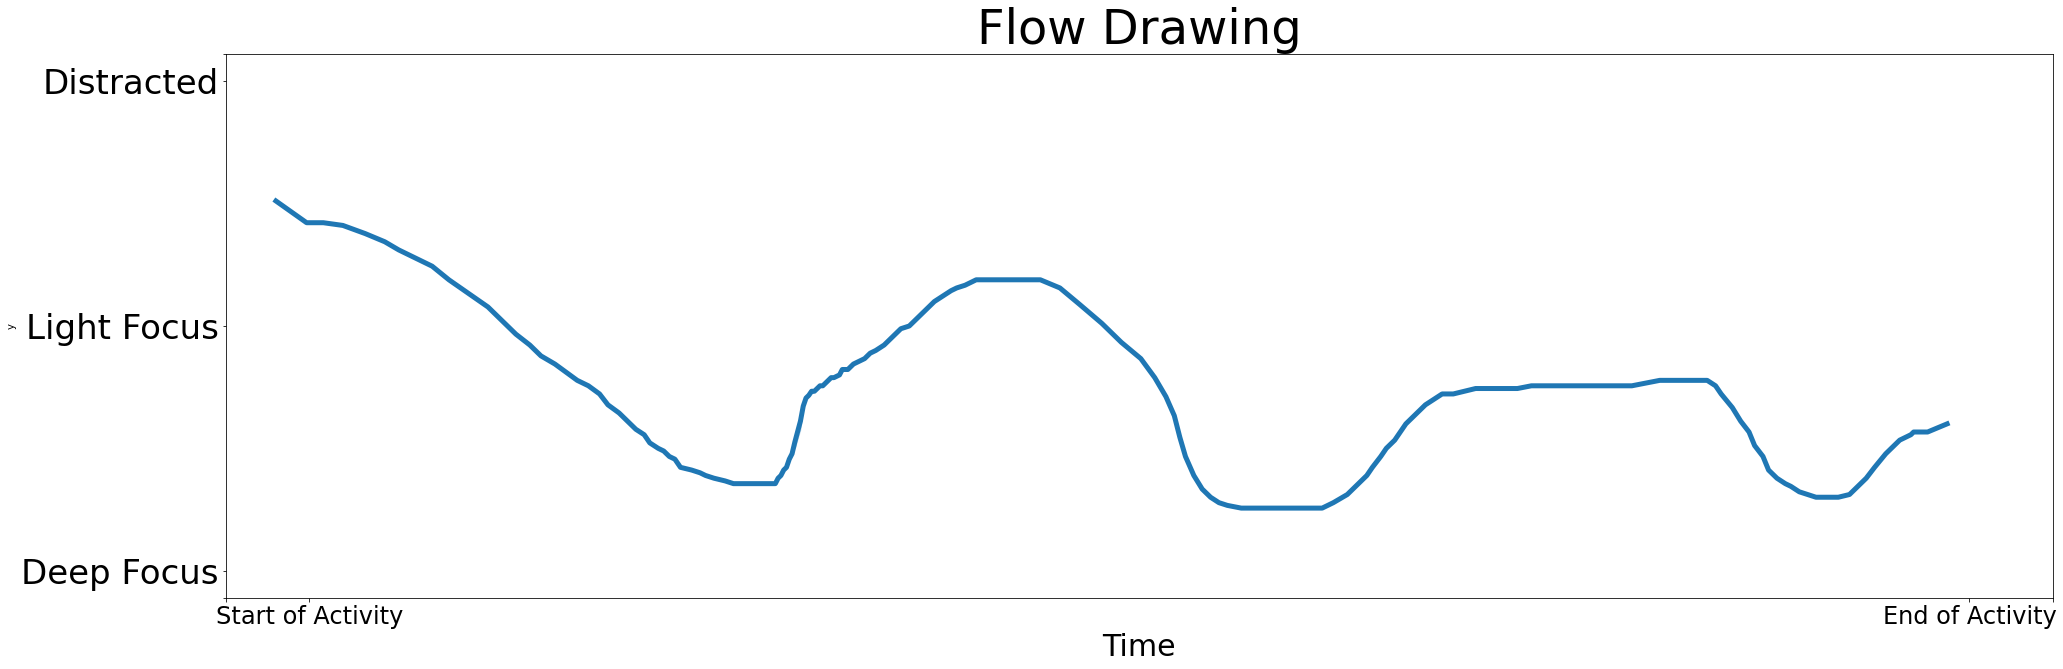

In [357]:
def plotFlowPath(survey_data):
    
    try:
        xy = survey_data['flowPath']
        canvassize = survey_data['flowCanvasSize']
    
    except:
        print('No flow path data')
        return
    
    xy_float = [float(i) for i in xy]

    # Create list of dictionaries representing coordinates
    coordinates = [{'x': xy_float[i], 'y': xy_float[i + 1]} for i in range(0, len(xy_float), 2)]

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(coordinates)

    # Define the size of the plot to match your canvas size (converted to inches)
    fig, ax = plt.subplots(figsize=(float(canvassize[0]) / 10, float(canvassize[1]) / 10))

    # Create the scatterplot
    sns.lineplot(data=df, x='x', y='y', lw=5, ax=ax)
    
    # Set title and labels
    plt.title('Flow Drawing', fontsize=48)
    #plt.set_xlabel('Time', fontsize=22)
    #plt.set_ylabel('Value', fontsize=22)
    

    ax.set_xticks([0, 15, float(canvassize[0])-15, float(canvassize[0])])
    ax.set_xticklabels(['','Start of Activity', 'End of Activity',''], fontsize=24)
    ax.set_yticks([0, 5, float(canvassize[1])/2, float(canvassize[1])-5, float(canvassize[1])])
    ax.set_yticklabels(['','Distracted', 'Light Focus', 'Deep Focus',''], fontsize=34)


    # Add x and y labels
    ax.set_xlabel('Time', fontsize=30)
    
    plt.xlim([0, 327.5])
    plt.ylim([0, 100])
    # Remove tick marks
    #plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)

    # Invert the y axis to match the typical screen/canvas coordinate system
    ax.invert_yaxis()

    # Show the plot
    plt.show()
    
plotFlowPath(df2['HomeFinalSurvey'])

## Accelerometer/Gyro Scratch

lets look at the raw data-- we see some serious drift in the raw Gyro data.
need to filter with kalman filter to get what we want.  Pretty involved; probably should do this in a separate script.

/var/folders/5h/k59m9tx93jx76_1mzqy0whv40000gn/T/ipykernel_70624/986687066.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(vector[0:2])


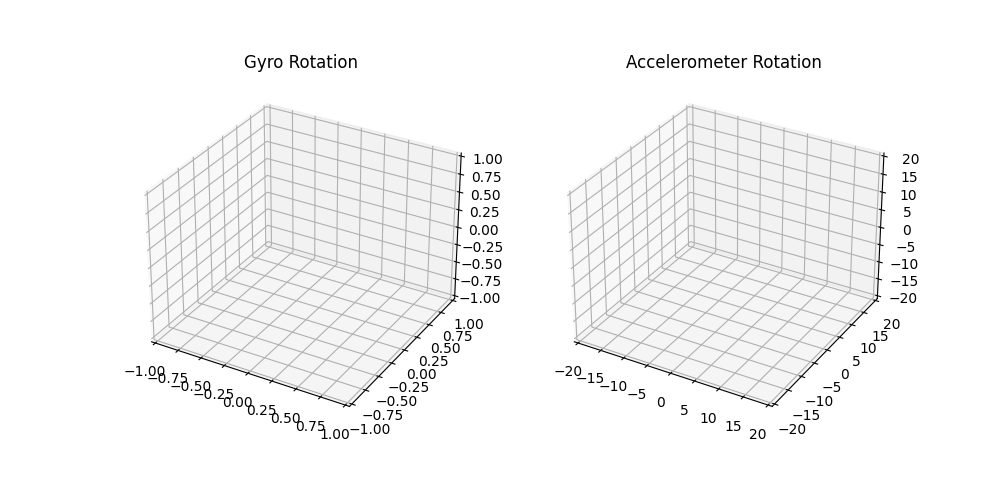

In [59]:
### Possible vid about head motion with gyro
## NOTE: this includes a small bias to drift back to [1,0,0] in 3D space; assumes we're starting at [1,0,0]

# Let's assume you have your 100Hz angular velocity data in a list of tuples;
# We'll downsample that to 20Hz
plot_freq = 5
angular_velocity_data = session_data[0]['gyro'][['x','y','z']].values[::int(100/plot_freq)]
angular_velocity_data = angular_velocity_data[:20*10] #take the first N sec

acc_data = session_data[0]['acc'][['x','y','z']].values[::int(50/plot_freq)]
acc_data = acc_data[:20*10] #take the first N sec


# This will store the history of the vector's orientation, to show as a trail in the animation
v_hist = []
a_hist = []

# Create a 3D figure
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_title('Gyro Rotation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlim([-20, 20])
ax2.set_ylim([-20, 20])
ax2.set_zlim([-20, 20])
ax2.set_title('Accelerometer Rotation')

mag = math.sqrt(acc_data[0][0]*acc_data[0][0] + acc_data[0][1]*acc_data[0][1] + acc_data[0][2]*acc_data[0][2])
v= [acc_data[0][0]/mag, acc_data[0][1]/mag, acc_data[0][2]/mag]

def update(frame):
    global v, v_hist

    # Clear the current plot
    ax.cla()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title('Gyro Rotation')

    # Calculate the new orientation based on the angular velocity
    angular_velocity = list(angular_velocity_data[frame])
    
    rotation_vector = np.array(angular_velocity) / plot_freq  # divide by frequency to get rotation per time step
    rotation = R.from_rotvec(rotation_vector)

    # Apply the rotation to the vector
    v = rotation.apply(v)
    v_hist.append(v)

    # Draw the vector
    ax.quiver(0, 0, 0, v[0], v[1], v[2], color='b')

    # Draw the trail
    if len(v_hist) > 1:
        x1s, y1s, z1s = zip(*v_hist)
        ax.plot(x1s, y1s, z1s, color='r')

    ax2.cla()
    ax2.set_xlim([-20, 20])
    ax2.set_ylim([-20, 20])
    ax2.set_zlim([-20, 20])
    ax2.set_title('Accelerometer Rotation')

    accel = list(acc_data[frame])
    a_hist.append(accel)
    
    ax2.quiver(0, 0, 0, accel[0], 0, 0, color='r')
    ax2.quiver(0, 0, 0, 0, accel[1], 0, color='g')
    ax2.quiver(0, 0, 0, 0, 0, accel[2], color='b')
    ax2.quiver(0, 0, 0, np.sum(accel[0]), np.sum(accel[1]), np.sum(accel[2]), color='k')

    # Draw the trail
    if len(a_hist) > 1:
        x2s, y2s, z2s = zip(*a_hist)
        ax2.plot(x2s, y2s, z2s, color='y')


# Create the animation
ani = FuncAnimation(fig, update, frames=len(angular_velocity_data), interval=1000/plot_freq)
plt.show()

## Accelerometer/Gyro Scratch

Let's use an extended kalman filter to combine gyro and accel data.  First we interpolate to 100Hz exact estimates (cubic), then we run the kalman filter algorithm.

In [37]:
session_data[0]['quaternions'].head()

,w,i,j,k
2023-04-22 14:39:54.890500+00:00,0.764576,-0.466940,-0.379169,-0.231565
2023-04-22 14:39:54.900500+00:00,0.667544,0.556292,0.451797,-0.202001
2023-04-22 14:39:54.910500+00:00,0.643212,0.575158,0.466630,-0.194235
2023-04-22 14:39:54.920500+00:00,0.627121,0.587017,0.475853,-0.188928
2023-04-22 14:39:54.930500+00:00,0.616612,0.594426,0.481681,-0.185553


In [41]:
# need it in i,j,k,w format for from_quat()
session_data[0]['quaternions'][['i', 'j', 'k', 'w']].values

array([[-0.46693995, -0.37916862, -0.23156503,  0.76457561],
       [ 0.55629197,  0.45179661, -0.20200062,  0.66754387],
       [ 0.57515792,  0.46663045, -0.19423474,  0.64321245],
       ...,
       [ 0.75617643,  0.40221687, -0.25861425,  0.44669617],
       [ 0.75601463,  0.40197162, -0.25872126,  0.44712863],
       [ 0.75584051,  0.40174161, -0.25887192,  0.44754232]])

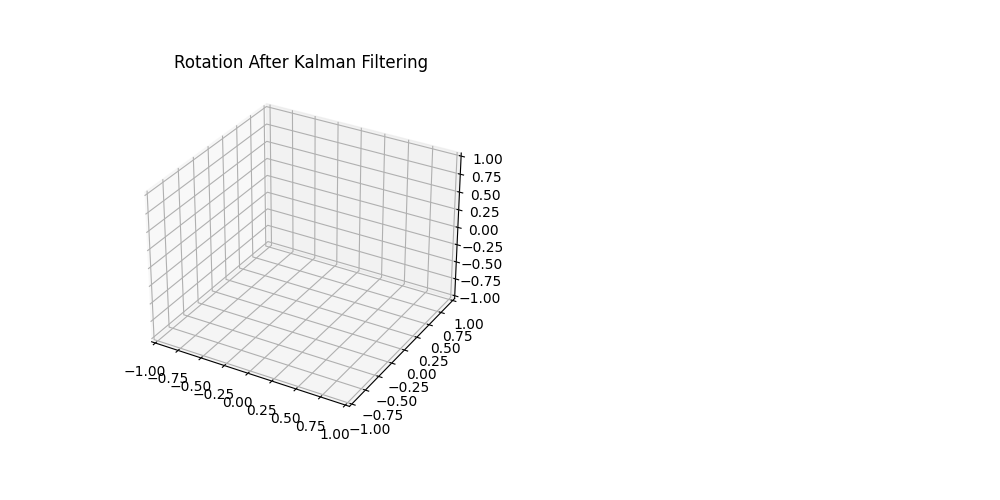

In [42]:
plot_freq = 5

data = session_data[0]['quaternions'][['i', 'j', 'k', 'w']].values[::int(100/plot_freq)]


# Create a 3D figure
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_title('Rotation After Kalman Filtering')

v = [0,1,0]
v_hist = []

def update(frame):
    global v, v_hist

    # Clear the current plot
    ax.cla()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title('Rotation After Kalman Filtering')

    quaternion = list(data[frame])
    rotation = R.from_quat(quaternion)
    v = rotation.apply([0, 1, 0])  # apply rotation to the vector [1,0,0]
    v_hist.append(v)

    # Draw the vector
    ax.quiver(0, 0, 0, v[0], v[1], v[2], color='b')

    # Draw the trail
    if len(v_hist) > 1:
        x1s, y1s, z1s = zip(*v_hist)
        ax.plot(x1s, y1s, z1s, color='r')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(data), interval=1000/plot_freq)
plt.show()

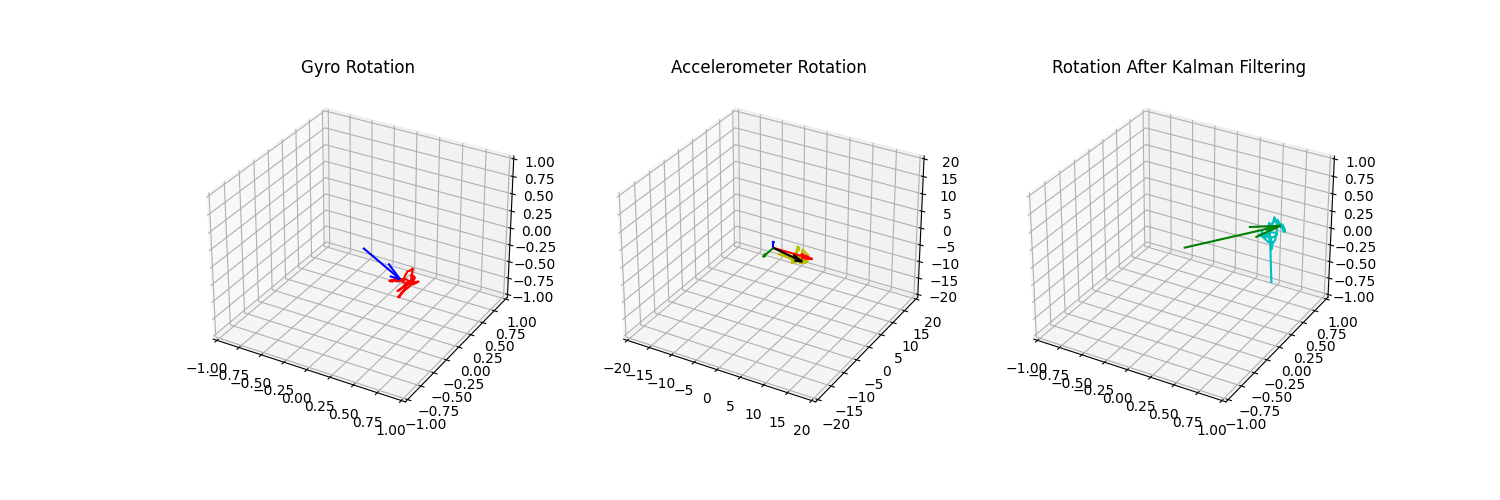

In [47]:
plot_freq = 5
angular_velocity_data = session_data[0]['gyro'][['x','y','z']].values[::int(100/plot_freq)]
acc_data = session_data[0]['acc'][['x','y','z']].values[::int(50/plot_freq)]
q_data = session_data[0]['quaternions'][['i', 'j', 'k', 'w']].values[::int(100/plot_freq)]

angular_velocity_data = angular_velocity_data[:20*10] #take the first N sec
acc_data = acc_data[:20*10] #take the first N sec
q_data = q_data[:20*10] #take the first N sec


# This will store the history of the vector's orientation, to show as a trail in the animation
v_hist = []
a_hist = []
vkal_hist = []

# Create a 3D figure
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(131, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_title('Gyro Rotation')

ax2 = fig.add_subplot(132, projection='3d')
ax2.set_xlim([-20, 20])
ax2.set_ylim([-20, 20])
ax2.set_zlim([-20, 20])
ax2.set_title('Accelerometer Rotation')

ax3 = fig.add_subplot(133, projection='3d')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.set_zlim([-1, 1])
ax3.set_title('Estimate after Kalman')

mag = math.sqrt(acc_data[0][0]*acc_data[0][0] + acc_data[0][1]*acc_data[0][1] + acc_data[0][2]*acc_data[0][2])
v= [acc_data[0][0]/mag, acc_data[0][1]/mag, acc_data[0][2]/mag]

def update(frame):
    global v, v_hist, a_hist, vkal_hist

    # Clear the current plot
    ax.cla()
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title('Gyro Rotation')

    # Calculate the new orientation based on the angular velocity
    angular_velocity = list(angular_velocity_data[frame])
    
    rotation_vector = np.array(angular_velocity) / plot_freq  # divide by frequency to get rotation per time step
    rotation = R.from_rotvec(rotation_vector)

    # Apply the rotation to the vector
    v = rotation.apply(v)
    v_hist.append(v)

    # Draw the vector
    ax.quiver(0, 0, 0, v[0], v[1], v[2], color='b')

    # Draw the trail
    if len(v_hist) > 1:
        x1s, y1s, z1s = zip(*v_hist)
        ax.plot(x1s, y1s, z1s, color='r')

    ax2.cla()
    ax2.set_xlim([-20, 20])
    ax2.set_ylim([-20, 20])
    ax2.set_zlim([-20, 20])
    ax2.set_title('Accelerometer Rotation')

    accel = list(acc_data[frame])
    a_hist.append(accel)
    
    ax2.quiver(0, 0, 0, accel[0], 0, 0, color='r')
    ax2.quiver(0, 0, 0, 0, accel[1], 0, color='g')
    ax2.quiver(0, 0, 0, 0, 0, accel[2], color='b')
    ax2.quiver(0, 0, 0, np.sum(accel[0]), np.sum(accel[1]), np.sum(accel[2]), color='k')

    # Draw the trail
    if len(a_hist) > 1:
        x2s, y2s, z2s = zip(*a_hist)
        ax2.plot(x2s, y2s, z2s, color='y')

    # Clear the current plot
    ax3.cla()
    ax3.set_xlim([-1, 1])
    ax3.set_ylim([-1, 1])
    ax3.set_zlim([-1, 1])
    ax3.set_title('Rotation After Kalman Filtering')

    quaternion = list(q_data[frame])
    rotation2 = R.from_quat(quaternion)
    vnew = rotation2.apply([0, 1, 0])  # apply rotation to the vector [1,0,0]
    vkal_hist.append(vnew)

    # Draw the vector
    ax3.quiver(0, 0, 0, vnew[0], vnew[1], vnew[2], color='g')

    # Draw the trail
    if len(vkal_hist) > 1:
        x1s, y1s, z1s = zip(*vkal_hist)
        ax3.plot(x1s, y1s, z1s, color='c')


# Create the animation
ani = FuncAnimation(fig, update, frames=len(angular_velocity_data), interval=1000/plot_freq)
ani.save('animation.mp4', writer='ffmpeg', fps=20)

## Blink Scratch

let's see what we have.  Prior algorithm may not work super well when people are walking around and talking; we mainly used it for sitting and working.

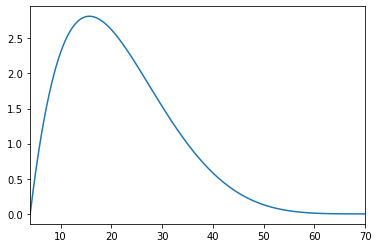

In [495]:
#A REASONABLE PRIOR OVER BLINKS PER MINUTE

# parameters for Beta distribution
alpha, beta = 2, 6
x = np.linspace(4, 70, 1000)
pdf = beta.pdf((x - 4) / 70, alpha, beta)

plt.plot(x, pdf)
plt.xlim(4, 70)
plt.show()

#now probability it's a blink for an individual blink is related to peak

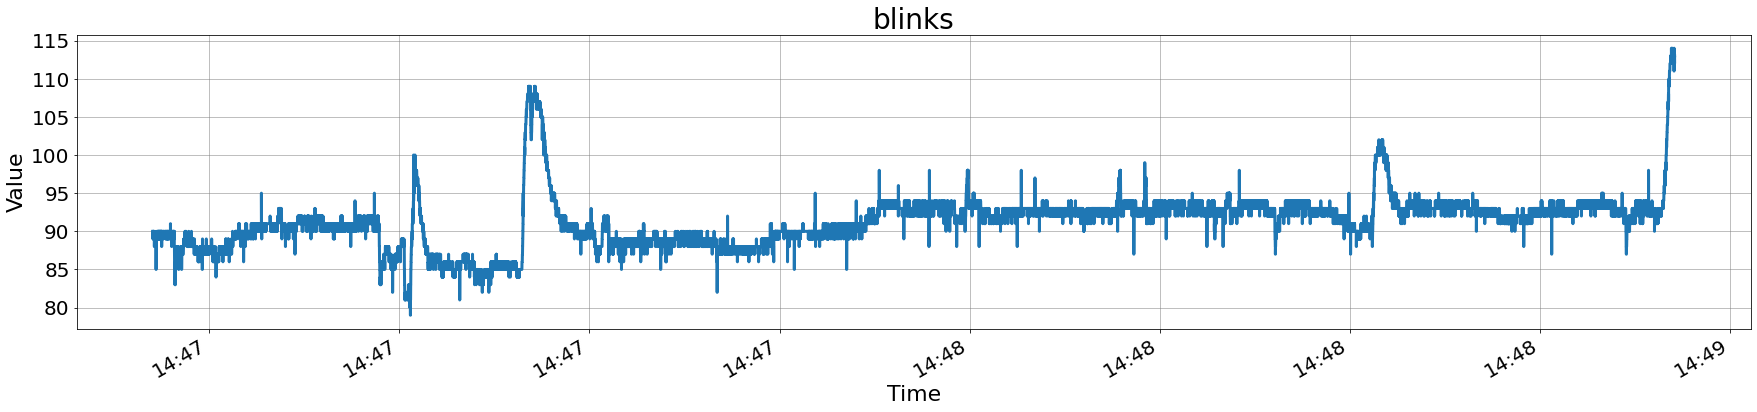

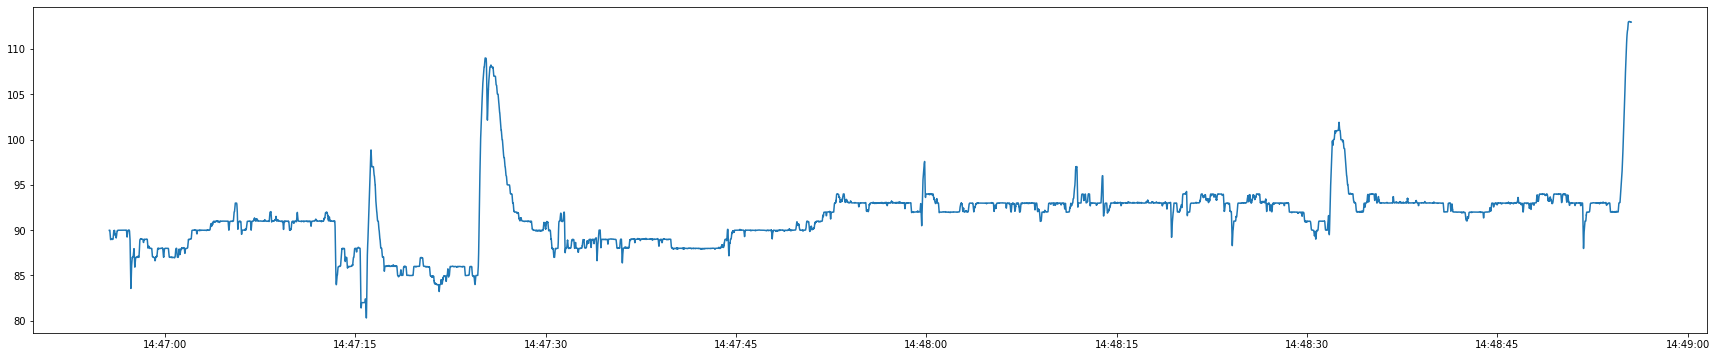

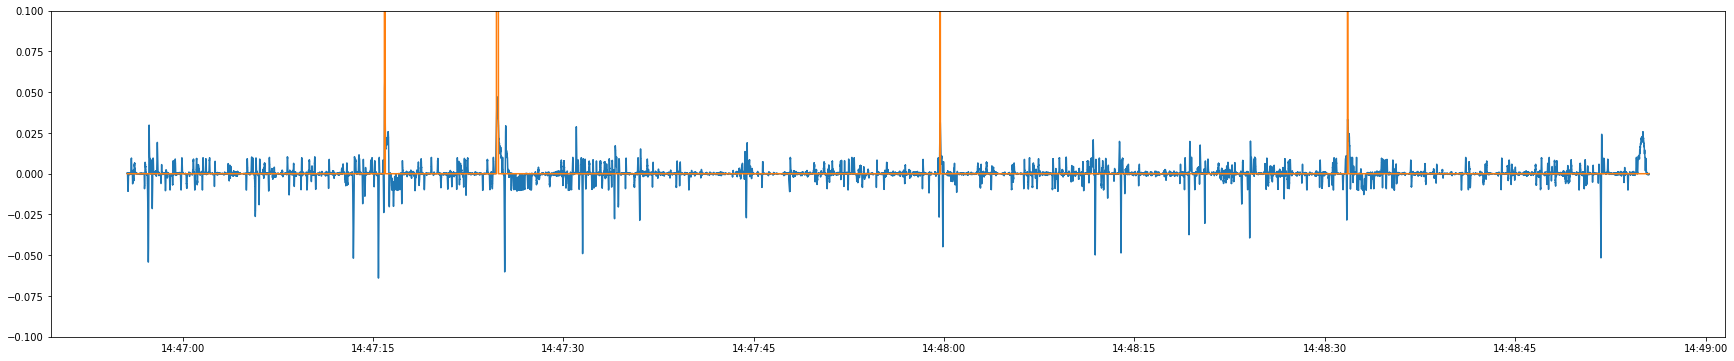

,vel_close,vel_open,duration_ms
timestamp,,,
2023-04-22 14:46:55.576000+00:00,0.8998,0.0108,0 days 00:00:00.099500
2023-04-22 14:47:15.884000+00:00,0.0574,0.0150,0 days 00:00:00.074000
2023-04-22 14:47:24.714500+00:00,0.0472,0.0254,0 days 00:00:00.132000
2023-04-22 14:47:24.802000+00:00,0.0422,0.0142,0 days 00:00:00.168000
2023-04-22 14:47:59.681000+00:00,0.0314,0.0038,0 days 00:00:00.170500
2023-04-22 14:48:31.782500+00:00,0.0332,0.0170,0 days 00:00:00.159000


In [521]:
#we want to tune our threshold.
#prior over blinks in a minute, 12. 5 seems unrealistically low, 45 is unrealistically high.


def grab_blinks(blink_sess, thresh=0.03, blink_dur_ms=175, lpf_samples=100, dx_lpf_samples=50, reverse=False):
    #get array of (1)timestamps of blinks, (2) [peak close velocity, peak open velocity], (3) duration
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'same') / w
    
    #step 1: LPF input, take derivative, LPF derivative
    smooth_input = moving_average(blink_sess['data'], lpf_samples)
    dx = np.append([np.nan], np.diff(smooth_input))
    smooth_dx = moving_average(dx, dx_lpf_samples)
    df_results = pd.DataFrame({'timestamp':blink_sess.index, 'dx':smooth_dx})
    
    fig, ax = plt.subplots(figsize=(30, 6))
    ax.plot(df_results['timestamp'][100:-100], smooth_input[100:-100])
    plt.show()

    
    
    #step 2, apply threshold
    if reverse:
        decision = (smooth_dx > thresh)
    else:
        decision = (smooth_dx < -1*thresh)

    fig, ax = plt.subplots(figsize=(30, 6))
    ax.plot(df_results['timestamp'][100:-100], df_results['dx'][100:-100])
    ax.plot(df_results['timestamp'][100:-100], decision[100:-100])
    plt.ylim([-0.1, 0.1])
    plt.show()
    #step 3, use this thresholded value to decide if we are blinking subject to debounce.
    #grab the blink time. within the bounds of the blink, find the duration and peak velocities using the derivative.
    df_blinks = pd.DataFrame()
    samples_per_blink = int(blink_dur_ms*2)  # sample at 2kHz so 1 sample == 0.5 ms
    samples_blink_debounce = int(samples_per_blink / 2)
    i, blinkrow = 0, {}
    while i<len(decision):
        if decision[i]: #we have a blink
            blinkrow['timestamp'] = df_results['timestamp'].iloc[i] #timestamp of this blink
            
            df_thisblink = df_results.iloc[i:i+samples_per_blink] #grab the data associated with this blink
            if reverse:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
            else:
                max_close = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].min()]
                max_open  = df_thisblink[df_thisblink['dx'] == df_thisblink['dx'].max()]
            
            blinkrow['vel_close'] = abs(max_close['dx'].iloc[0]) #peak close velocity
            blinkrow['vel_open']  = abs(max_open['dx'].iloc[-1]) #peak open velocity
            blinkrow['duration_ms'] = max_open['timestamp'].iloc[-1] - max_close['timestamp'].iloc[0] #duration
            
            df_blinks = pd.concat([df_blinks, pd.DataFrame([blinkrow])], ignore_index=True)
            i += samples_blink_debounce #move ahead debounce samples before checking for blinks again
        else: i += 1
            
    df_blinks.set_index('timestamp', inplace=True)
    return df_blinks

start_time= 2000*60*7 #2kHz * N sec into stream, ignore prior samples
duration  = 2000*60*2 #2kHz * 60 sec/min * N min duration


plot_df(b[start_time:start_time+duration][['data']],'blinks')

grab_blinks(b[start_time:start_time+duration], reverse=True)

## Pullling it Together
We should save this data by section.  The excel sheets generated by my survey and study tools serves as the cannonical clock-- it (very nicely) will have the starting and ending timestamp of each condition

- lab = (demo, tetris_1, tetris_2, flow_1, flow_2) 
- home = (tetris_1, tetris_2, flow_1, flow_2, flow_final)

Once we have the data roughly processed, we can organize them into these sections to start working.

## Making a Cool Video

This section is the start of a cool video-- basically, pulling the tetris video, overlaying the live datastreams, and creating a new video.

It would be really cool to have a virtual head and arm moving based on the signals we got and little eyes on the head that are blinking;
not sure we're going to get that far though.  At the moment, it just embeds the video with properly timestamped/synced E4 Data (and might need a little re-write because the timestamp column in my E4 df is now its index)

In [49]:
class VideoPlayer:
    def __init__(self, user, sess, df, output='output.mp4'):
        
        full_path = os.path.join('Data/' + user, user + '_' + sess)
        # Find video file and extract timestamp
        for file_name in os.listdir(full_path):
            if file_name.endswith(".MP4"):
                video_file = os.path.join(full_path, file_name)
                # Assuming timestamp is the number after "Final" in the filename
                timestamp_match = re.search(r"Final(\d+)", file_name)
                if timestamp_match:
                    self.video_timestamp = int(timestamp_match.group(1))*1000
                break
        
        self.cap = cv2.VideoCapture(video_file)
        self.df = df.sort_values('timestamp')
        
        self.data = {key: [] for key in df['datatype'].unique()}
        self.timestamps = {key: [] for key in df['datatype'].unique()}
        self.index = 0
        
        ret, frame = self.cap.read()
        self.width = frame.shape[1] // 4 * 3
        self.height = frame.shape[0] // 2
        
        self.center_width = self.width // 3
        self.center_height = self.height // 2
        self.center_offset = self.height // 4
        
        self.plot_width = self.center_width
        self.plot_height = self.height // 3

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        self.out = cv2.VideoWriter(output, fourcc, 20.0, (self.width, self.height))
        self.left_side_data = ['ACC', 'EDA', 'TEMP']
        self.right_side_data = ['BVP', 'IBI', 'HR']

    def update_data(self):
        while self.index < len(self.df):
            new_data = self.df.iloc[self.index]
            datatype = new_data['datatype']

            current_time = self.cap.get(cv2.CAP_PROP_POS_MSEC) + self.video_timestamp
            #print('got current timestamp' + str(current_time))
            new_time = pd.to_datetime(new_data['timestamp']).timestamp() * 1000
            #print('timestamp of df[' + str(self.index) + '] is ' + str(new_time))
            if new_time > current_time:
                break
            
            data_list = new_data['data']
            if not isinstance(data_list[0], list):
                data_list = [data_list]
            
            self.data[datatype].append(data_list)
            self.timestamps[datatype].append(new_time)

            '''
            # Limit the amount of data and timestamps to the latest 50 points and last 5 seconds.
            if len(self.data[datatype]) > 1000:
                self.data[datatype] = self.data[datatype][-1000:]
                self.timestamps[datatype] = self.timestamps[datatype][-1000:]
            '''
            
            if self.timestamps[datatype][-1] - self.timestamps[datatype][0] > 30000:  # 25 seconds
                idx = next(i for i, v in enumerate(self.timestamps[datatype]) if self.timestamps[datatype][-1] - v <= 30000)
                self.data[datatype] = self.data[datatype][idx:]
                self.timestamps[datatype] = self.timestamps[datatype][idx:]

            self.index += 1

    def draw_plot(self, datatype):
        fig = Figure()
        FigureCanvas(fig)
        ax = fig.subplots()

        #print('drawing plot ' + datatype)
        
        plot_data = np.array(self.data[datatype]).transpose()
        for d in plot_data:
            '''
            print('timestamps')
            print(self.timestamps[datatype])
            print('data')
            print(d)
            '''
            ax.plot(self.timestamps[datatype], d[0])
        
        ax.set_title(datatype)
        fig.tight_layout()

        ax.figure.canvas.draw()
        plot_img = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
        plot_img = plot_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return plot_img

    def progress(self, count, total, status=''):
        bar_len = 60
        filled_len = int(round(bar_len * count / float(total)))
        bar = '=' * filled_len + '-' * (bar_len - filled_len)
        clear_output(wait=True)
        display('{} [{}] {}'.format(status, bar, count))
        
    def run(self, speed=1):
        total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_count = 0
        
        while(self.cap.isOpened() and frame_count<100000):
            ret, frame = self.cap.read()
            if not ret:
                break

            if frame_count % speed == 0:
                self.update_data()
                
                frame = cv2.resize(frame, (self.center_width, self.center_height))
                frame_outer = np.zeros((self.height, self.center_width, 3), dtype=np.uint8)
                frame_outer[self.center_offset : self.center_offset + self.center_height, 0: self.center_width] = frame
                plots_img = np.zeros((self.height, self.width, 3), dtype=np.uint8)

                for i, datatype in enumerate(self.left_side_data):
                    plot_img = self.draw_plot(datatype)

                    plot_img = cv2.resize(plot_img, (self.plot_width, self.plot_height))
                    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2RGB)

                    x = 0
                    y = self.plot_height * i

                    plots_img[y:y+self.plot_height, x:x+self.plot_width] = plot_img
                
                for i, datatype in enumerate(self.right_side_data):
                    plot_img = self.draw_plot(datatype)

                    plot_img = cv2.resize(plot_img, (self.plot_width, self.plot_height))
                    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2RGB)

                    x = self.plot_width * 2
                    y = self.plot_height * i

                    plots_img[y:y+self.plot_height, x:x+self.plot_width] = plot_img

                final_frame = cv2.hconcat([plots_img[:, :self.plot_width], frame_outer, plots_img[:, self.plot_width*2:]])
                self.out.write(final_frame)

                self.progress(frame_count, total_frames, status='Processing video')
            frame_count += 1

        self.cap.release()
        self.out.release()

In [50]:
df = load_session_data('P9', 'sess1')
player = VideoPlayer('P9', 'sess1', df, 'output.mp4')
player.run(speed=1000)

'Processing video [==========================================------------------] 99000'

In [2]:
df.head(100)

,timestamp,datatype,data
0,2023-04-21 14:29:37.000000,TEMP,[28.49]
1,2023-04-21 14:29:37.000000,ACC,"[39, -10, -54]"
2,2023-04-21 14:29:37.000000,BVP,[-0.0]
3,2023-04-21 14:29:37.000000,EDA,[0.0]
4,2023-04-21 14:29:37.015625,BVP,[-0.0]
...,...,...,...
95,2023-04-21 14:29:37.906250,BVP,[59.83]
96,2023-04-21 14:29:37.906250,ACC,"[22, 30, -36]"
97,2023-04-21 14:29:37.921875,BVP,[64.97]
98,2023-04-21 14:29:37.937500,BVP,[69.58]


In [12]:
# ACC, make accelerometer data into assumed motion vector.

# ACC, look at magnitude and parse 'low motion' - nothing happening, 'motion' - typing, small Gs, 'high motion' - big guestures and motion
# this will allow us to look at the other data highlighted by likelihood of a motion artifact

# ACC, self-similarity matrix application; use full vector and lets assume gestures have a certain time constant-- 
# say 1/3 of a second if we're looking at someone doing a hobby like music knitting, etc
# lets also look for patterns that suggest things like typing or video game guestures, where individual motor movements
# aren't really reasonable to model and we need to look at agreggate motion

# BVP, check for corruptions with Accelerometer data by just plotting it with high motion and low motion areas highlighted
# BVP/HR/IBI, run a HR detection algorithm, compare against the provided HR/IBI.  If they differ, average and confidence.

# EDA, check for corruptions with Accelerometer data. If an issue mark with accelerometer about trust
# SCR and SCL, search for model of pulses

# TEMP compare against Accelerometer data; if corrupted, throw out or trust less.  We will probably average this data out to match the slow rates
# we're collecting other temp data at.




## Gyro Data
# seems we're getting (from BNO) rad/s X,Y,Z -- same X,Y,Z as accelerometer.  3 16 bit numbers

#uint_16 on stm32
#logged with format string 'hhhII' in react-- short short short unsigned_int unsigned_int


#Example 3 of BNO080 Library from Sparkfun-- almost certainly what our code is based on.
#Enables Gyro with same command enableGyro(), which calls the same feature report ID (0x02 = SENSOR_REPORTID_GYROSCOPE)
#In example, uses getGyroX (and getGyroY/getGyroZ) and reports rad/s.

#reports a FLOAT that is computed using this function:

#rawGyroX/Y/Z values are set to be equal to data1,data2,data3 coming in from bus.
#
#	uint16_t data1 = (uint16_t)shtpData[5 + 5] << 8 | shtpData[5 + 4];
#	uint16_t data2 = (uint16_t)shtpData[5 + 7] << 8 | shtpData[5 + 6];
#	uint16_t data3 = (uint16_t)shtpData[5 + 9] << 8 | shtpData[5 + 8];

# we have the exact same code on our microcontroller packaging the data and sending it over.

# qPoint == 9 (defined in header)

#float BNO080::qToFloat(int16_t fixedPointValue, uint8_t qPoint)
#{
#
#	float qFloat = fixedPointValue;
#	qFloat *= pow(2, qPoint * -1);
#	return (qFloat);
#}

#that *= 2^-9 is equivalent to a divide by 512.

#Head rotation speeds can vary widely depending on the specific activity and individual. 
#However, studies have suggested that the angular velocity of the head during normal activities typically 
#lies in the range of 20-120 degrees/second.

#To convert these values into radians per second (rad/s), remember that 1 radian = 57.3 degrees. So:
#
#    20 degrees/second = 20/57.3 = 0.35 rad/s
#    120 degrees/second = 120/57.3 = 2.09 rad/s



#Temp Data
# watch temp calibrated based on measurements against a product off amazon: 21.2 + (6.7/5.4) * (float(WATCH_TEMP)-24)
#'normal' forehead temp is 35.4 - 37.4 C

#Temp data from glasses is noisy AF-- seems that's actually mostly in thermistor readings, not thermopile, and these thermistors should be pretty low-passable.
#Cleaning up each individual data source before combining them to get a celcius reading gives a really good result.